# 1. Introduction

Voir le notebook de description

# 2. Démarche méthodologique

Voir le notebook de description

# 3. Exploration des données

## <a name="C31">3.1 Chargement<a>

### <a name="C2311">3.1.1 Importation des librairies utiles et options<a>

In [2]:
import os
import sys
import time
import mlflow
import mlflow.tensorflow

from preprocessing import *



import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import  PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer

from wordcloud import WordCloud
import sklearn
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import FastText
import xgboost as xgb
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
sklearn.metrics.adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
#, confusion_matrix,

#from sklearn.cross_validation import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import tensorflow_hub as hub
import tokenization

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.utils.vis_utils import plot_model


from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
import re

import keras
from sklearn.metrics import confusion_matrix,f1_score,classification_report

# import necessary libraries
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics import classification_report
import en_core_web_sm

#import geopandas as gpd
#from haversine import Unit
#from sklearn import metrics
#import plotly.express as px
#from datetime import datetime
#from haversine import haversine
import matplotlib.pyplot as plt
#from sklearn import preprocessing
#from sklearn.cluster import DBSCAN
#from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
#from sklearn.cluster import kmeans_plusplus
#from scipy.cluster.hierarchy import linkage
#from sklearn.metrics import silhouette_score
#from sklearn.preprocessing import LabelEncoder
#from scipy.cluster.hierarchy import dendrogram
#from yellowbrick.cluster import KElbowVisualizer
#from sklearn.cluster import AgglomerativeClustering
#from yellowbrick.cluster import SilhouetteVisualizer
import flask

print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
print("re version:", re.__version__)
print("nltk version:", nltk.__version__)
print("gensim version:", gensim.__version__)
print("Tensorflow version:", tensorflow.__version__)
print("Flask version:", flask.__version__)

Python version: 3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
Version info.: sys.version_info(major=3, minor=10, micro=10, releaselevel='final', serial=0)
pandas version: 1.5.3
numpy version: 1.23.5
skearn version: 1.2.2
re version: 2.2.1
nltk version: 3.8.1
gensim version: 4.3.1
Tensorflow version: 2.12.0
Flask version: 2.2.3


In [2]:
# Pour eviter de tronquer les listes affichées car le dataset est important en terme de taille
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### <a name="C312">3.1.2 Les fonctions</a>

#### <a name="C3121">3.1.2.1 Score LSTM</a>

In [4]:
def score_lstm(estimator, y_pred,X_train,X_test,y_train,y_test):
    print("La proportion de target dans le jeu d'entrainement :")
    print(y_train.value_counts(normalize=True))
    print("La proportion des prédictions faite est :")
    print(pd.Series(y_pred).value_counts(normalize=True)) #Pour utiliser value_counts, il faut transformer notre vecteur en series
    print("--------------------------------------------------------------------------------")
    print("Voici les résultats :")
    '''tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    print(f"score train : {tr_score} ; score test : {te_score}")'''
    print("----------------------------------------")
    display(confusion(y_test, y_pred))
    print("----------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------")
    
    print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test,y_pred),2))
       
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)

    
    plt.figure(figsize=(10,10))
    plt.title("Receiver Operator Characteristic - ROC")
    plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.axis('tight')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

#### <a name="C3122">3.1.2.2 Calcul modèle</a>

In [5]:
def calcul_modele(modele_estimator, modele_parameters, modele_grid_search,X_train, y_train, X_test, y_test):
    
    start = time.time()
    modele_grid_search.fit(X_train, y_train)
    end = time.time()
    print("Le temps d'entrainement (en secondes) est :")
    print(end - start)
    
    print("Les meilleurs paramètres sont",modele_grid_search.best_params_)
    print("Le meilleur score est :",modele_grid_search.best_score_)
    
    y_pred = modele_grid_search.predict(X_test)
    
    score(modele_grid_search,y_pred,X_train,X_test,y_train,y_test)
    
    print("ARI score = ", adjusted_rand_score(y_test, y_pred))
    
    

#### <a name="C3123">3.1.2.3 Score</a>

In [6]:
def score(estimator, y_pred,X_train,X_test,y_train,y_test):
    print("La proportion de target dans le jeu d'entrainement :")
    print(y_train.value_counts(normalize=True))
    print("La proportion des prédictions faite est :")
    print(pd.Series(y_pred).value_counts(normalize=True)) #Pour utiliser value_counts, il faut transformer notre vecteur en series
    print("--------------------------------------------------------------------------------")
    print("Voici les résultats :")
    tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    print(f"score train : {tr_score} ; score test : {te_score}")
    print("----------------------------------------")
    display(confusion(y_test, y_pred))
    print("----------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------")
    #Pour tous les cas sauf K-means:
    print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test,y_pred),2))
       
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)

    
    plt.figure(figsize=(10,10))
    plt.title("Receiver Operator Characteristic - ROC")
    plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.axis('tight')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

#### <a name="C3124">3.1.2.4 Matrice de confusion</a>

In [7]:
def confusion(y_test,y_pred) :
    '''affiche une matrice de confusion bien comprehensible'''
    mat=confusion_matrix(y_test,y_pred)
    mat=pd.DataFrame(mat)
    mat.columns=[f"pred_{i}" for i in mat.columns]
    mat.index=[f"test_{i}" for i in mat.index]
    return mat #pour afficher la matrice de confusion lors de l'appel de la fonction

#### <a name="C3125">3.1.2.5 Affichage features</a>

In [8]:
def affichage_features(emb, feat, ngram, compared_sentence=0):
    print(ngram,"bag-of-words: ")
    print(feat.get_feature_names_out(), "\n")
    print(ngram,"bag-of-feature: ")
    print(test_cv_1gram.vocabulary_, "\n")
    print("BoW matrix:")
    print(pd.DataFrame(emb.transpose(), index = feat.get_feature_names_out()).head(), "\n")
    print(ngram,"vector example:")
    print(df_sentiment_ech["clean_text_lem"][compared_sentence])
    print(emb[compared_sentence], "\n")

#### <a name="C3126">3.1.2.6 Traitement du texte</a>

In [9]:
def process_text(doc,
                   rejoin=False,
                   lemm_or_stemm=None,
                   freq_rare_words=None,
                   min_len_words=None,
                   force_is_alpha=True,
                   eng_words=None,
                   extra_words=None,
                   stop_words=None) :
    
    # list unique words
    #if not list_rare_words:
        #list_rare_words=[] #Si non on crée liste vide
        
    # forcer le document à etre en minuscule
    doc=doc.lower().strip() # Mise en minuscule et suppression des espaces avant et apres la chaine de caractère
    #print("-----> Passage en minuscule effectué") 
    
    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_token_list=tokenizer.tokenize(doc)
    #print("-----> Passage en token effectué") 
    
    # stopwords : suppresion des stop_words de la liste
    cleaned_tokens_list = [w for w in  raw_token_list if w not in stop_words]
    #print("-----> Suppression des stopwords effectué") 
    
    # création de la liste des mots rares
    tmp=pd.Series(cleaned_tokens_list).value_counts()
    list_rare_words=tmp[tmp==freq_rare_words]
    list_rare_words=list(list_rare_words.index) #transformation du vecteur en une liste
    #print("-----> Liste des mots rares qui apparaissent", freq_rare_words, "fois effectuée. Il y a", len(list_rare_words) ,"mots différents")
    
    
   #no rare token : suppression des tokens appartenant à la liste des mots rares
    non_rare_tokens = [w for w in  cleaned_tokens_list if w not in list_rare_words]
    #print("-----> Suppression des mots rares effectué")
    
    # no more len words : selection des token ayant une longueur min
    more_than_N= [w for w in non_rare_tokens if len(w) >= min_len_words]
    #print("-----> Suppression des mots ayant moins de", min_len_words,"lettres effectué")
    
    #On garde ou non les tokens 100% alphabétiques
    if force_is_alpha :
        alpha_tokens= [w for w in more_than_N if w.isalpha()]
        #print("-----> Conservation des mots 100% alphabétiques effectué")
    else : 
            alpha_tokens =  more_than_N
        
        
    #lem or stem
    if lemm_or_stemm=="lem":
        trans=WordNetLemmatizer()
        trans_text=[trans.lemmatize(i) for i in alpha_tokens]
        #print("-----> Lemmatisation effectué")
    else :
        trans=PorterStemmer()
        trans_text=[trans.stem(i) for i in alpha_tokens]
        #print("-----> Racinisation effectué")
        
    # in english
    if eng_words :
        engl_text=[i for i in trans_text if i in eng_words]
        #print("-----> Conservation des mots anglais effectué")
    else :
        engl_text=trans_text
        
    # Suppresion des mots communs entre les 2 catégories (extra words)
    if extra_words :
        final = [w for w in  engl_text if w not in extra_words] 
    else :
        final=trans_text
        
    #renvoi d'une liste de token ou une chaine de caractère
      
    if rejoin :
        return " ".join(final)
    
    
    #print("-> Corpus ready <-")
    return  final#, list_rare_words


#### <a name="C3127">3.1.2.7 Affichage information token</a>

In [10]:
def affichage_info_tokens(tokens):
    """affiche les informations du corpus"""
    print(f"nb tokens {len(tokens)}, nb token unique {len(set(tokens))}")
    print(tokens[:30]) # Affichage des 30 premiers élements de ma liste

#### <a name="C3128">3.1.2.8 Imprimer corpus</a>

In [11]:
def print_sample(sub_df,n_samp=10):
    
    samp=sub_df.sample(n_samp)
    
    for idx , ser in samp.iterrows():
        txt_1=f"target : {ser['target']}\n"
        print(txt_1 + ser['text']+"..."+"\n\n")

#### <a name="C3129">3.1.2.9  Affichage des manquants   </a>

In [12]:
def affichage_manquants(df):
    nb_na = df.isnull().sum()
    nb_na = nb_na[nb_na > 0]

    # Création d'un dataframe avec les manquants
    df_miss = pd.DataFrame(nb_na).reset_index()
    df_miss.columns = ["colonne", "quantite_manquante"]
    df_miss.sort_values("quantite_manquante", ascending=False, inplace=True)

    # Ajout du % de manquants
    df_miss["% manquant"] = round(
        (df_miss["quantite_manquante"] / df.shape[0]) * 100, 2
    )
    df_miss.reset_index(drop=True, inplace=True)
    display(df_miss)

#### <a name="C31210">3.1.2.10 Analyse univariée  </a>

In [13]:
def univarie(df, col, bins):
    print("---------------------------------")
    print(df[col].name)
    # Mesures de tendances centrales
    print("moy:\n", df[col].mean())
    print("med:\n", df[col].median())
    print("mod:\n", df[col].mode())

    # Mesures de dispersion :
    print("Ecart type:\n", df[col].std(ddof=0))  # Ecart type empirique
    print(
        "Var:\n", df[col].var(ddof=0)
    )  # Variance empirique --> var non supporter par datetime type
    print("Coefficient de variation CV :", df[col].std() / df[col].mean())

    print(df[col].describe())

    # Visualisation de la distribution
    plt.figure()
    plt.style.use("fivethirtyeight")
    plt.hist(df[col], edgecolor="k", bins=bins)
    plt.title("Répartition")
    plt.xlabel(col)
    plt.ylabel("Count")

    print("---------------------------------")

### <a name="C313">3.1.3 Chargement des données provenant du fichier CSV</a>

In [14]:
# Création des noms des colonnes car le fichier n'en possède pas
col_names = ["target", "ids", "date", "flag", "user", "text"]
df_sentiment140 = pd.read_csv("input/data/sentiment140/training.1600000.processed.noemoticon.csv", names = col_names, encoding = 'ISO-8859-1')

In [15]:
# Création d'une copie pour récupérer les informations d'origines si necessaire"
df_sentiment = df_sentiment140.copy()

## 3.2 Présentation de la structure

### <a name="C321">3.2.1 Nombre de lignes/colonnes et types</a>

In [16]:
df_sentiment.info()
display(df_sentiment.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


## 3.3 Nettoyage

### <a name="C331"> 3.3.1 Les manquants</a> 

In [17]:
affichage_manquants(df_sentiment)

,colonne,quantite_manquante,% manquant


In [18]:
df_sentiment.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

### <a name="C332"> 3.3.2 Les types</a> 

In [19]:
df_sentiment.dtypes.value_counts()

object    4
int64     2
dtype: int64

In [20]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [21]:
# Changement de type
df_sentiment["ids"] = df_sentiment["ids"].astype("object")
df_sentiment["date"] = pd.to_datetime(df_sentiment["date"])

C:\Users\Utilisateur\anaconda3\envs\projet7\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [22]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  object        
 2   date    1600000 non-null  datetime64[ns]
 3   flag    1600000 non-null  object        
 4   user    1600000 non-null  object        
 5   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 73.2+ MB


### <a name="C333">3.3.3 Les doublons </a>

In [23]:
# Détection des doublons sur chaque colonne par une boucle for 

for col in df_sentiment.columns :
    n=df_sentiment.duplicated(subset=col).sum()
    print(f"col : {col} -> duplicated : {n}")

col : target -> duplicated : 1599998
col : ids -> duplicated : 1685
col : date -> duplicated : 825637
col : flag -> duplicated : 1599999
col : user -> duplicated : 940225
col : text -> duplicated : 18534


In [24]:
# Détection des doublons sur toutes les lignes en considérant toutes les colonnes

df_tmp = df_sentiment[df_sentiment.duplicated()]
df_tmp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   target  0 non-null      int64         
 1   ids     0 non-null      object        
 2   date    0 non-null      datetime64[ns]
 3   flag    0 non-null      object        
 4   user    0 non-null      object        
 5   text    0 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 0.0+ bytes


In [25]:
# Détection des doublons sur toutes les lignes en mettant de coté "target"
df_tmp = df_sentiment[df_sentiment[["ids","date","flag","user","text"]].duplicated()]
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 800261 to 1599931
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   target  1685 non-null   int64         
 1   ids     1685 non-null   object        
 2   date    1685 non-null   datetime64[ns]
 3   flag    1685 non-null   object        
 4   user    1685 non-null   object        
 5   text    1685 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 92.1+ KB


In [26]:
# On voit ici que 1685 lignes ont des targets différentes malgré leurs ressemblance à au moins une autre

In [27]:
(len(df_tmp)*2)/1600000 #0.2% du dataset. On va donc supprimer toutes les lignes concernées (un reclassement manuel prendrait enormément de temps)

0.00210625

In [28]:
df_sentiment.drop_duplicates(subset=["ids","date","flag","user","text"], keep=False, inplace=True, ignore_index=True)
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596630 entries, 0 to 1596629
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1596630 non-null  int64         
 1   ids     1596630 non-null  object        
 2   date    1596630 non-null  datetime64[ns]
 3   flag    1596630 non-null  object        
 4   user    1596630 non-null  object        
 5   text    1596630 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 73.1+ MB


In [29]:
df_sentiment.head()

,target,ids,date,flag,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [30]:
df_tmp = df_sentiment[df_sentiment[["target","text"]].duplicated()]
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16289 entries, 1932 to 1596399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   target  16289 non-null  int64         
 1   ids     16289 non-null  object        
 2   date    16289 non-null  datetime64[ns]
 3   flag    16289 non-null  object        
 4   user    16289 non-null  object        
 5   text    16289 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 890.8+ KB


In [31]:
df_tmp.head()

,target,ids,date,flag,user,text
1932,0,1468267465,2009-04-07 00:38:38,NO_QUERY,ei8htyOne,and so the editing of 3000 wedding shots begins
2140,0,1468316454,2009-04-07 00:56:00,NO_QUERY,Augustina22CA,"im lonely keep me company! 22 female, california"
3726,0,1468664220,2009-04-07 03:02:08,NO_QUERY,FranciscoAndre,"I'm not liking that new iTunes Pricing at all. I mean, I've seen several songs at $1.29, but not only one at $0.69!"
3729,0,1468664704,2009-04-07 03:02:17,NO_QUERY,ammaryasir,"cant eat, drink or breath properly thanks to the bad throat infection"
4145,0,1468756463,2009-04-07 03:33:56,NO_QUERY,lkm1989,has a cold


In [32]:
df_sentiment.drop_duplicates(subset=["target","text"], keep=False, inplace=True, ignore_index=True)
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573736 entries, 0 to 1573735
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1573736 non-null  int64         
 1   ids     1573736 non-null  object        
 2   date    1573736 non-null  datetime64[ns]
 3   flag    1573736 non-null  object        
 4   user    1573736 non-null  object        
 5   text    1573736 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 72.0+ MB


In [33]:
df_tmp = df_sentiment[df_sentiment[["text"]].duplicated()]
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 785482 to 1569295
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   target  247 non-null    int64         
 1   ids     247 non-null    object        
 2   date    247 non-null    datetime64[ns]
 3   flag    247 non-null    object        
 4   user    247 non-null    object        
 5   text    247 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 13.5+ KB


In [34]:
df_sentiment.drop_duplicates(subset=["text"], keep=False, inplace=True, ignore_index=True)
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573242 entries, 0 to 1573241
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1573242 non-null  int64         
 1   ids     1573242 non-null  object        
 2   date    1573242 non-null  datetime64[ns]
 3   flag    1573242 non-null  object        
 4   user    1573242 non-null  object        
 5   text    1573242 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 72.0+ MB


In [35]:
df_sentiment.select_dtypes("int64").apply(pd.Series.nunique, axis=0)

target    2
dtype: int64

In [36]:
# Détection des valeurs uniques des "objets" sur chaque dataframe
df_sentiment.select_dtypes("object").apply(pd.Series.nunique, axis=0)

ids     1573242
flag          1
user     651475
text    1573242
dtype: int64

In [37]:
df_sentiment["flag"].unique()

array(['NO_QUERY'], dtype=object)

In [38]:
# On voit ici que flag a juste kla valeur "NO QUERY" qu ne va pas nous servir. Je vais donc supprimer cette colonne
df_sentiment.drop("flag", axis="columns", inplace=True)
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573242 entries, 0 to 1573241
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1573242 non-null  int64         
 1   ids     1573242 non-null  object        
 2   date    1573242 non-null  datetime64[ns]
 3   user    1573242 non-null  object        
 4   text    1573242 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 60.0+ MB


In [39]:
# Détection des valeurs uniques des "datetime" sur chaque dataframe
df_sentiment.select_dtypes("datetime").apply(pd.Series.nunique, axis=0)

date    767540
dtype: int64

In [40]:
# Détection des doublons sur chaque colonne par une boucle for 

for col in df_sentiment.columns :
    n=df_sentiment.duplicated(subset=col).sum()
    print(f"col : {col} -> duplicated : {n}")

col : target -> duplicated : 1573240
col : ids -> duplicated : 0
col : date -> duplicated : 805702
col : user -> duplicated : 921767
col : text -> duplicated : 0


### <a name="C334">3.3.4 Outliers </a>

In [41]:
df_sentiment.describe(include="int64")

,target
count,1.573242e+06
mean,2.005634e+00
std,1.999993e+00
min,0.000000e+00
25%,0.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,4.000000e+00


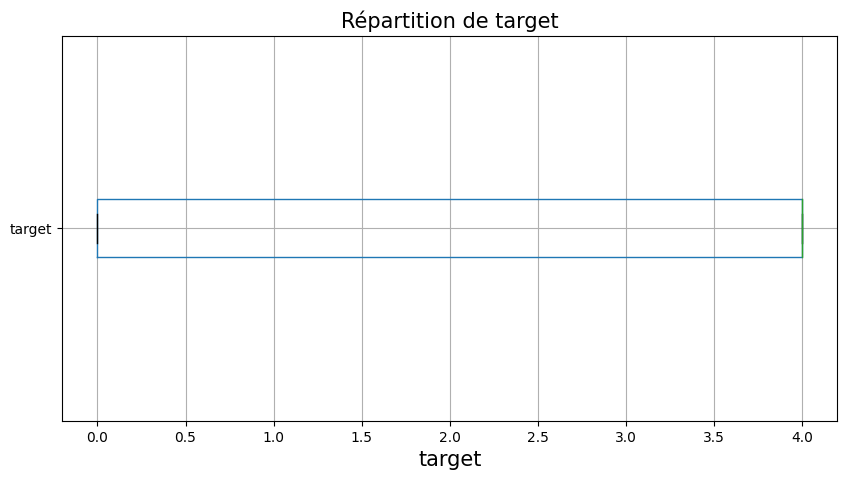

In [42]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de target", fontsize=15)
df_sentiment.boxplot(column="target", vert=False, notch=False)
plt.xlabel("target", fontsize=15)
plt.show()

In [43]:
# Remplacement de la target 4 par 1
df_tmp=df_sentiment.loc[df_sentiment["target"]==4]
df_tmp.head()

for index in df_tmp.index:
    df_sentiment.loc[index, "target"]=1

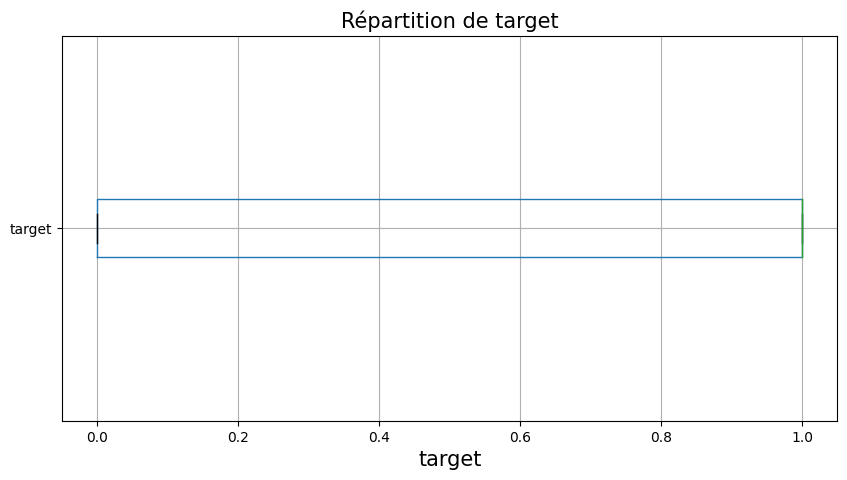

In [44]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de target", fontsize=15)
df_sentiment.boxplot(column="target", vert=False, notch=False)
plt.xlabel("target", fontsize=15)
plt.show()

In [45]:
df_sentiment.describe(include="object")

,ids,user,text
count,1573242,1573242,1573242
unique,1573242,651475,1573242
top,1467810369,lost_dog,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
freq,1,549,1


In [46]:
df_sentiment.describe(include="datetime")

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3496\3323399532.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_sentiment.describe(include="datetime")


,date
count,1573242
unique,767540
top,2009-06-15 12:53:14
freq,20
first,2009-04-06 22:19:45
last,2009-06-25 10:28:31


### <a name="C335"> 3.3.5 Selection des colonnes d'un point de vu métier</a> 

In [47]:
df_sentiment=df_sentiment[["target","text"]].copy()
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573242 entries, 0 to 1573241
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1573242 non-null  int64 
 1   text    1573242 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.0+ MB


### <a name="C336"> 3.3.6 Bilan du nettoyage</a> 

In [48]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573242 entries, 0 to 1573241
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1573242 non-null  int64 
 1   text    1573242 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.0+ MB


In [49]:
# Détection des doublons sur chaque colonne par une boucle for 

for col in df_sentiment.columns :
    n=df_sentiment.duplicated(subset=col).sum()
    print(f"col : {col} -> duplicated : {n}")

col : target -> duplicated : 1573240
col : text -> duplicated : 0


In [50]:
df_sentiment.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [51]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573242 entries, 0 to 1573241
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1573242 non-null  int64 
 1   text    1573242 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.0+ MB


In [52]:
'''Test de la fonction preprocessing (nettoyage de la dataframe initiale)'''

# Création des noms des colonnes car le fichier n'en possède pas
'''col_names = ["target", "ids", "date", "flag", "user", "text"]
df_sent140 = pd.read_csv("input/data/sentiment140/training.1600000.processed.noemoticon.csv", names = col_names, encoding = 'ISO-8859-1')

# Création d'une copie pour récupérer les informations d'origines si necessaire"
df_sent = df_sent140.copy()

# Test de la fonction preprocessing
df_sent=fct_preprocessing(df_sent)
df_sent.head()'''

'col_names = ["target", "ids", "date", "flag", "user", "text"]\ndf_sent140 = pd.read_csv("input/data/sentiment140/training.1600000.processed.noemoticon.csv", names = col_names, encoding = \'ISO-8859-1\')\n\n# Création d\'une copie pour récupérer les informations d\'origines si necessaire"\ndf_sent = df_sent140.copy()\n\n# Test de la fonction preprocessing\ndf_sent=fct_preprocessing(df_sent)\ndf_sent.head()'

In [53]:
'''df_sent.info()'''

'df_sent.info()'

In [54]:
#Vérification si la dataframe ressorti par la fonction preprocessing est identique à celle traitée "step by step"
'''df_sent.compare(df_sentiment)'''

'df_sent.compare(df_sentiment)'

In [55]:
#STOP

# 4 Analyses

## <a name="C41">4.1 Analyses univariées </a>

### <a name="C411">4.1.1 target </a>

---------------------------------
target
moy:
 0.5014085563441607
med:
 1.0
mod:
 0    1
Name: target, dtype: int64
Ecart type:
 0.49999801596508886
Var:
 0.24999801596902524
Coefficient de variation CV : 0.9971871611398494
count    1.573242e+06
mean     5.014086e-01
std      4.999982e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: target, dtype: float64
---------------------------------


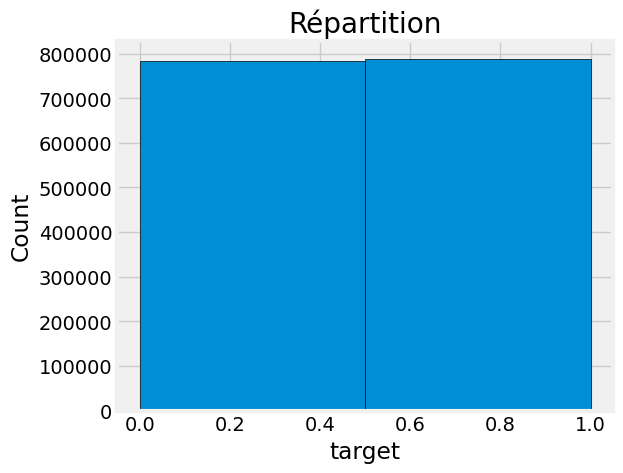

In [56]:
univarie(df_sentiment,"target",2)

In [57]:
df_sentiment["target"].value_counts(normalize=True)

1    0.501409
0    0.498591
Name: target, dtype: float64

In [58]:
df_sentiment["target"].value_counts()

1    788837
0    784405
Name: target, dtype: int64

<AxesSubplot: ylabel='target'>

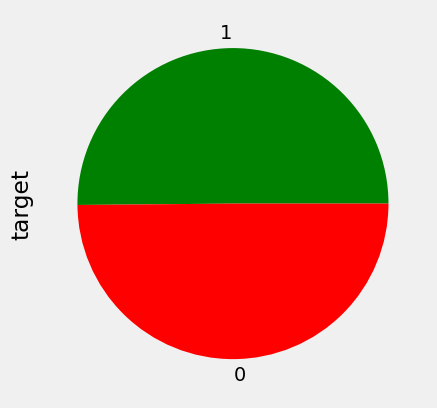

In [59]:
colors = ({"green": 'green',"red":'red'})
df_sentiment.target.value_counts().plot(kind="pie", colors=colors)

### <a name="C412">4.1.2 text </a>

<AxesSubplot: >

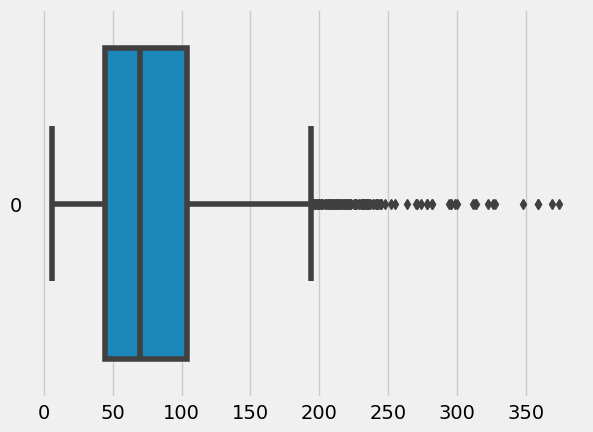

In [60]:
tmp = df_sentiment.text.str.len()
sns.boxplot(tmp, orient="h")

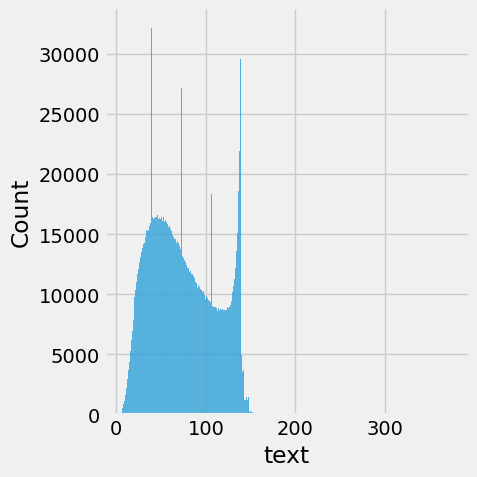

In [61]:
sns.displot(tmp, height=5,aspect=1)

In [62]:
tmp.describe()

count    1.573242e+06
mean     7.459163e+01
std      3.612753e+01
min      6.000000e+00
25%      4.400000e+01
50%      7.000000e+01
75%      1.040000e+02
max      3.740000e+02
Name: text, dtype: float64

In [63]:
#Création d'une nouvelle colonne : feature ingeneering pour afficher le nombre de lettre dans le commentaire (espace et pontuation comprise)
df_sentiment["_len_txt"]=tmp
df_sentiment.head()

,target,text,_len_txt
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",115
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,111
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",111


## <a name="C42">4.2 Analyses multivarées</a>

In [64]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573242 entries, 0 to 1573241
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1573242 non-null  int64 
 1   text      1573242 non-null  object
 2   _len_txt  1573242 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 36.0+ MB


In [65]:
corr=df_sentiment[["target","_len_txt"]].corr()
corr

,target,_len_txt
target,1.000000,-0.011878
_len_txt,-0.011878,1.000000


<AxesSubplot: >

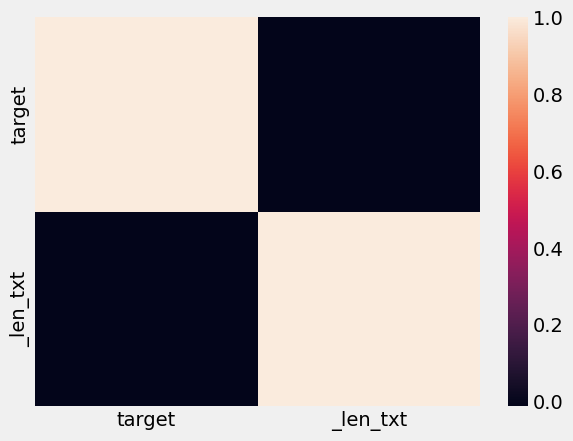

In [66]:
sns.heatmap(corr)

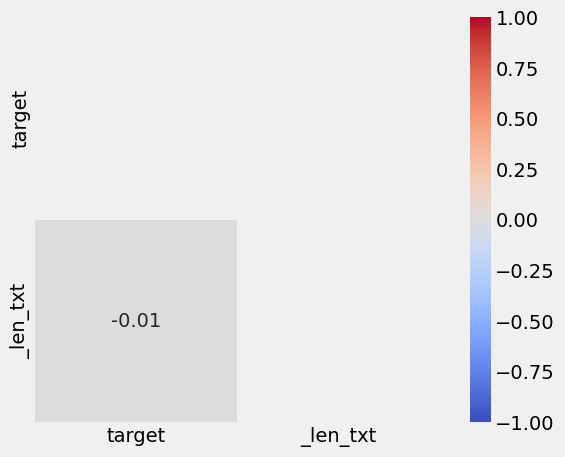

In [67]:
# affichage que de la diagonale
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

fid, ax = plt.subplots(1,1, figsize=(7,5))
ax=sns.heatmap(corr, mask=mask, vmin=-1,vmax=1,cmap="coolwarm", annot=True, fmt=".2f", square=True)

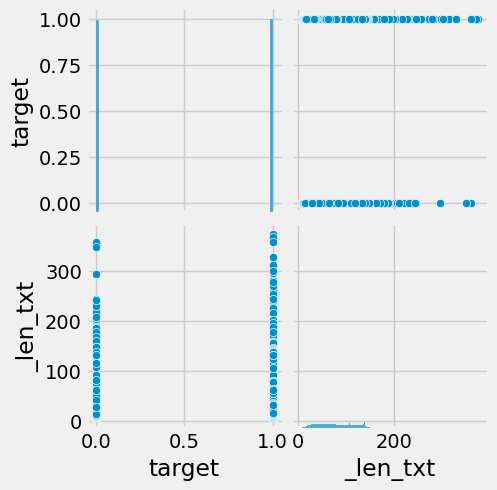

In [68]:
sns.pairplot(df_sentiment)

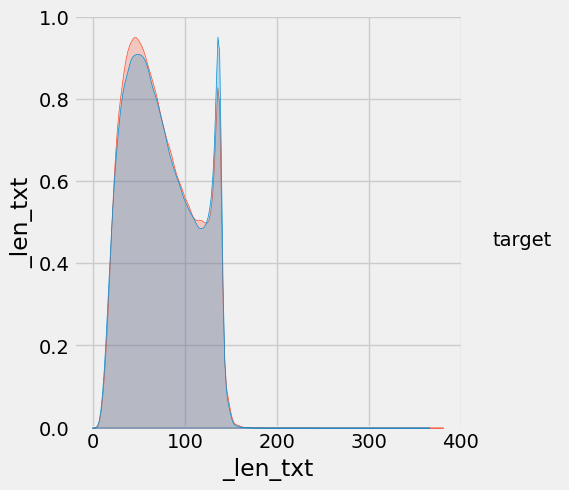

In [69]:
sns.pairplot(df_sentiment, height=5,aspect=1, hue="target")

In [70]:
df_sentiment.sort_values("_len_txt").head(10)

,target,text,_len_txt
1031222,1,hey,6
1051504,1,Yes,6
1208071,1,and*,6
303948,0,Ugh,6
204600,0,ouch,6
4156,0,just,6
290282,0,@hostx,7
485332,0,I mean,7
124144,0,MONday,7
818881,1,*heart,7


In [71]:
df_tmp=df_sentiment.loc[df_sentiment["_len_txt"]==9]
df_tmp.head(10)

,target,text,_len_txt
1319,0,is coldd,9
4312,0,Eww snow,9
4991,0,Ill head,9
6290,0,SNOW?!?!,9
12335,0,The Sims,9
12967,0,@ASOT400,9
15368,0,@Itayhod,9
16392,0,Awww why,9
17157,0,UGHHHHH.,9
18558,0,up again,9


In [72]:
df_tmp=df_sentiment.loc[df_sentiment["_len_txt"]==18]
df_tmp.head(10)

,target,text,_len_txt
194,0,wanttss to go out,18
443,0,my throat is raw.,18
821,0,it is really cold,18
1032,0,i miss my 808 fam,18
1423,0,i &lt;3 CIGS..RIP,18
1719,0,Bed... Work in am,18
2561,0,still in germany!,18
3264,0,need cuddling now,18
3478,0,@iamloz_JsPR ouch,18
3699,0,feeling low today,18


In [73]:
# Suppression de la colonne _len_txt car l'on va se concenter sur target et text
df_sentiment.drop(columns="_len_txt", inplace=True)
df_sentiment.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


## <a name="C43">4.3 Exploration du corpus</a>

In [74]:
df_samp=df_sentiment.sample(20)
df_samp

,target,text
65372,0,Just watched episode 3x03 of Primeval. OMGWTFBBQ?!?!? Am not sure I want to watch the rest of the season now.
1144465,1,@ian_122191 When yun MTV movie awards?
844551,1,@Sideache Tomorrow I get to babysit my 6 year old &amp; 3 year old nephews! 'Twill be fun times with Aunt Tam! #hhrs #tcot #hcb
69584,0,wishes she could be prettier than her sisters L !
1537830,1,Playing 1 vs 100 over Xbox Live now. Room is already full with my friends.
474780,0,already missing meowchell!!
582282,0,@stygldpnyby CRAP! I totally forgot! You could only go the 22nd right?? Social Distortion is that night and I already bought my tix!
726919,0,going down south all day today. text meeee!
604306,0,Ugh phone I'll be back later.
1049670,1,Going to deborah's show with cameron bolus!


In [75]:
print_sample(df_samp)

target : 1
@mileycyrus Miley I love you ALWAYS even if i'm dead I will keep you safe and watch over you from haven I really wish you a happy life ...


target : 0
why is it so hard to find bradley cooper icons ...


target : 1
Playing 1 vs 100 over Xbox Live now. Room is already full with my friends. ...


target : 0
@stygldpnyby CRAP! I totally forgot! You could only go the 22nd right?? Social Distortion is that night and I already bought my tix! ...


target : 0
wishes she could be prettier than her sisters L  !...


target : 0
Wow, thats sad  Poor Trevor...


target : 0
Just watched episode 3x03 of Primeval. OMGWTFBBQ?!?!?  Am not sure I want to watch the rest of the season now. ...


target : 0
@emscum o pls save me lol it would make my wkend complete ...


target : 0
n more college ...


target : 0
Ugh phone I'll be back later. ...




In [76]:
df_sentiment_0=df_sentiment[df_sentiment.target ==0]
df_sentiment_0.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [77]:
df_sentiment_1=df_sentiment[df_sentiment.target ==1]
df_sentiment_1.head()

,target,text
784405,1,I LOVE @Health4UandPets u guys r the best!!
784406,1,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
784407,1,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
784408,1,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
784409,1,@LovesBrooklyn2 he has that effect on everyone


# <a name="C5">5 Préparation du texte</a>

## <a name="C51">5.1 Définition des mots génériques</a>

### <a name="C511"> 5.1.1 Définition des stopwords</a> 

In [78]:
# stopwords : liste de mots trop génériques pour être informatif (ils sont très utilisés dans le langage)
stop_words=set(stopwords.words('english'))
print(stop_words)

{'if', 'further', 'its', 'and', 've', 're', 'into', 'then', 'his', 'there', 'up', 'in', 'each', "won't", "needn't", 'below', 'from', "you'd", 'have', 'ma', 'who', 'than', 'to', 'how', 'did', 'do', 'hasn', 'is', 'own', 'mustn', 'having', 'll', 'against', 'your', 'that', "that'll", 'over', 'can', 'couldn', 'only', 'here', 'why', "shan't", 'themselves', 'shouldn', 'their', 'through', 'you', 'again', 'm', 'both', 'those', 'wasn', 'should', 'with', "weren't", "shouldn't", "you've", 'mightn', 'won', 'by', 'so', 'above', 'as', 'are', 'had', 'same', 'when', "should've", 't', 'itself', 'them', 'once', 'for', 'haven', 'few', 'more', 'some', 'where', 'nor', 'such', 'ain', 'she', 'theirs', 'no', 'was', 'now', 'most', 'didn', 'yourselves', "hasn't", 'until', 'before', "haven't", 'be', 'needn', "doesn't", 'too', 'hadn', 'just', 'which', 'being', 'has', 'yours', 'd', 'off', 'been', "she's", "it's", 'we', 'down', 'hers', "you'll", 'herself', 'the', 'isn', "couldn't", "didn't", 'because', "wasn't", 'ab

### <a name="C512"> 5.1.2 Définition des mots anglais</a> 

In [79]:
# Conservation des mots anglais
# 30 mot au hasard en anglais selon NLTK
pd.Series(words.words()).sample(30)

23821            bloodworm
157060    proparticipation
136909               padre
90306            hypsiloid
107973          logicaster
78571                 Gogo
90315         Hypsistarian
156326            procurer
149771          policlinic
88502         hydatidiform
83479             heirloom
25882              bravely
3736            afterwards
19189          bathochrome
61321      empiriocritical
202239           Thiospira
162641        radiological
75313         ganophyllite
96269        interjaculate
138087         panellation
9641          anthraflavic
119678          morrowless
89236         hyobranchial
66308           excoriable
141258              pegbox
67032              exposer
198722                 tau
205171         townspeople
188438          stalagmite
35909            chrysalid
dtype: object

In [80]:
# Nombre total de mots
len(set(words.words()))

235892

In [81]:
# prise en compte que des mots lower
eng_words=[i.lower() for i in words.words()]
eng_words[:30]

['a',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'aani',
 'aardvark',
 'aardwolf',
 'aaron',
 'aaronic',
 'aaronical',
 'aaronite',
 'aaronitic',
 'aaru',
 'ab',
 'aba',
 'ababdeh',
 'ababua',
 'abac',
 'abaca',
 'abacate',
 'abacay',
 'abacinate',
 'abacination',
 'abaciscus',
 'abacist',
 'aback',
 'abactinal',
 'abactinally']

In [82]:
len(set(eng_words))

234377

In [83]:
ps=PorterStemmer()
eng_words_stem=[ps.stem(i) for i in eng_words]
affichage_info_tokens(eng_words_stem)

nb tokens 236736, nb token unique 178311
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaron', 'aaron', 'aaronit', 'aaronit', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abac', 'abacay', 'abacin', 'abacin', 'abaciscu', 'abacist', 'aback', 'abactin', 'abactin']


In [84]:
len(set(eng_words_stem))

178311

In [85]:
lm=WordNetLemmatizer()
eng_words_lem=[lm.lemmatize(i) for i in eng_words]
affichage_info_tokens(eng_words_lem)

nb tokens 236736, nb token unique 233450
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaronic', 'aaronical', 'aaronite', 'aaronitic', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [86]:
len(set(eng_words_lem))

233450

## <a name="C52"> 5.2 Mise en place du corpus</a> 

### <a name="C521"> 5.2.1 Prise en compte d'un échantillon</a> 

In [87]:
n=10000

In [88]:
df_sentiment_ech_0=df_sentiment_0.sample(n=n,random_state=55)
df_sentiment_ech_1=df_sentiment_1.sample(n=n,random_state=55)
df_sentiment_ech=pd.concat([df_sentiment_ech_0, df_sentiment_ech_1])
df_sentiment_ech.reset_index(drop=True, inplace=True)
df_sentiment_ech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  20000 non-null  int64 
 1   text    20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


<AxesSubplot: ylabel='target'>

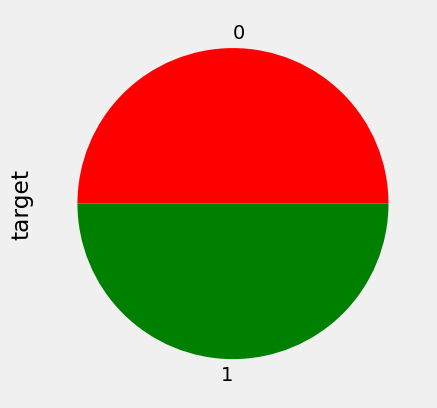

In [89]:
colors = ({"red":'red',"green": 'green'})
df_sentiment_ech.target.value_counts().plot(kind="pie", colors=colors)

In [90]:
df_sentiment_ech["target"].value_counts(normalize=True)

0    0.5
1    0.5
Name: target, dtype: float64

In [91]:
df_sentiment_ech["target"].value_counts()

0    10000
1    10000
Name: target, dtype: int64

In [92]:
df_sentiment_ech.head()

,target,text
0,0,@VARSITYFC guys I got so excited because I'm going with my church group on the 26th to six flags and I was like omg perfect! Man
1,0,"@benjorg Benny, when is AFS gonna start touring again!? I miss all of you!!"
2,0,@RobertsEmma Loooong way to go before that happens
3,0,it's so cold! [i don't wanna go to school!]
4,0,soooo nice outt wish i was seein my lovess day26 at summerjam whtev hotjam was insanee nd brian lovess me so does drake soo BYE!! lmfao


### <a name="C522"> 5.2.2 Création des corpus entier et analyse</a> 

In [93]:
raw_corpus_ech = " ".join(df_sentiment_ech.text.values)
raw_corpus_ech[:1_000]

"@VARSITYFC guys I got so excited because I'm going with my church group on the 26th to six flags and I was like omg perfect! Man  @benjorg Benny, when is AFS gonna start touring again!? I miss all of you!!  @RobertsEmma Loooong way to go before that happens  it's so cold! [i don't wanna go to school!]  soooo nice outt wish i was seein my lovess day26 at summerjam  whtev hotjam was insanee nd brian lovess me so does drake soo BYE!! lmfao Phone keeps vibrating and it on my lap too  i let my mom take A SIP of my bubble tea and 1/4 of the cup's gone  worst cramp ever in my hip.  @qlipped hahahaha good morning!! Well if that's really ur location I'm on my way!! Lol j/k that's where I got lost when I went there  @thomasdurden http://twitpic.com/4gowx - Wish I could be there, but sadly, I&quot;m in MI, and it's quite a drive.  I know this is going to sound lame but can I follow myself? Why is that even an option?...hope this didn't wake @merayda.  @loverocka fine (I'm mad your already hollyw

In [94]:
raw_corpus_ech_0 = " ".join(df_sentiment_ech_0.text.values)
raw_corpus_ech_0[:1_000]

"@VARSITYFC guys I got so excited because I'm going with my church group on the 26th to six flags and I was like omg perfect! Man  @benjorg Benny, when is AFS gonna start touring again!? I miss all of you!!  @RobertsEmma Loooong way to go before that happens  it's so cold! [i don't wanna go to school!]  soooo nice outt wish i was seein my lovess day26 at summerjam  whtev hotjam was insanee nd brian lovess me so does drake soo BYE!! lmfao Phone keeps vibrating and it on my lap too  i let my mom take A SIP of my bubble tea and 1/4 of the cup's gone  worst cramp ever in my hip.  @qlipped hahahaha good morning!! Well if that's really ur location I'm on my way!! Lol j/k that's where I got lost when I went there  @thomasdurden http://twitpic.com/4gowx - Wish I could be there, but sadly, I&quot;m in MI, and it's quite a drive.  I know this is going to sound lame but can I follow myself? Why is that even an option?...hope this didn't wake @merayda.  @loverocka fine (I'm mad your already hollyw

In [95]:
raw_corpus_ech_1 = " ".join(df_sentiment_ech_1.text.values)
raw_corpus_ech_1[:1_000]

"@jisele one of my favorites! that and &quot;Brand new&quot; remix  @robindelano Yeah!!!  its been too long girl! I broke the news to my mom that @michaelsheen would be playing Aro in New Moon. Her reaction: 'NOOOO!'  My reaction: 'Hell yes!'     sharing thoughts with the moon  Watched Yes Man, it was good  http://tinyurl.com/dbrc88 @V1SH4L have a cool and &quot;thoughtless&quot;   sunday with ur family? here in gulf sunday is the first working day so vr all set to work!! Liked &quot;#groovy on #android. It's getting closer...  http://twitgoo.com/srbp&quot; http://ff.im/-3Zg2M I would love to be a kid again today and do nothing but play outside for hours  ahh nice. is chilling by the pool with colb and kenz  just woke up. I'm such a lazy ass I didn't run today  oh well Having a great day everyone?Well I hope evrybody's having a great time  Have a tidycity.org activity today.. A clean up  @carosombrero hahaha true that....but it was definitely worth it because he's cute  @lawmansbabe ge

In [96]:
#Nombre de caractères
print(len(raw_corpus_ech))

1511451


In [97]:
#Nombre de caractères
print(len(raw_corpus_ech_0))

759292


In [98]:
#Nombre de caractères
print(len(raw_corpus_ech_1))

752158


In [99]:
corpus_ech =process_text(raw_corpus_ech,rejoin=False,lemm_or_stemm="lem",freq_rare_words=5,min_len_words = 3,eng_words=eng_words_lem,stop_words=stop_words)

In [100]:
corpus_ech_0 =process_text(raw_corpus_ech_0,rejoin=False,lemm_or_stemm="lem",freq_rare_words=5,min_len_words = 3,eng_words=eng_words_lem,stop_words=stop_words)

In [101]:
corpus_ech_1 =process_text(raw_corpus_ech_1,rejoin=False,lemm_or_stemm="lem",freq_rare_words=5,min_len_words = 3,eng_words=eng_words_lem,stop_words=stop_words)

In [102]:
#Regardons les mots en communs entre les 2 corpus 0 et 1 pour les n premiers mots les plus fréquent de chaque liste
n=20
doublons=[i for i in pd.Series(corpus_ech_0).value_counts().head(n).index
          if i in pd.Series(corpus_ech_1).value_counts().head(n).index]
doublons

['day',
 'get',
 'like',
 'today',
 'got',
 'going',
 'back',
 'time',
 'one',
 'good',
 'know',
 'lol']

In [103]:
corpus_ech_0 =process_text(raw_corpus_ech_0,rejoin=False,lemm_or_stemm="lem",freq_rare_words=5,min_len_words = 3,eng_words=eng_words_lem, extra_words=doublons,stop_words=stop_words)

In [104]:
corpus_ech_1 =process_text(raw_corpus_ech_1,rejoin=False,lemm_or_stemm="lem",freq_rare_words=5,min_len_words = 3,eng_words=eng_words_lem,extra_words=doublons,stop_words=stop_words)

In [105]:
affichage_info_tokens(corpus_ech)

nb tokens 140617, nb token unique 24654
['varsityfc', 'guy', 'got', 'excited', 'going', 'church', 'group', 'six', 'flag', 'like', 'omg', 'perfect', 'man', 'benjorg', 'benny', 'afs', 'gonna', 'start', 'touring', 'miss', 'robertsemma', 'loooong', 'way', 'happens', 'cold', 'wanna', 'school', 'soooo', 'nice', 'outt']


In [106]:
affichage_info_tokens(corpus_ech_0)

nb tokens 50195, nb token unique 6084
['guy', 'excited', 'church', 'group', 'six', 'flag', 'perfect', 'man', 'benny', 'start', 'touring', 'miss', 'way', 'cold', 'school', 'nice', 'wish', 'love', 'brian', 'love', 'bye', 'phone', 'keep', 'vibrating', 'lap', 'let', 'take', 'sip', 'bubble', 'tea']


In [107]:
affichage_info_tokens(corpus_ech_1)

nb tokens 47315, nb token unique 6333
['favorite', 'quot', 'brand', 'new', 'quot', 'remix', 'yeah', 'long', 'girl', 'broke', 'news', 'would', 'aro', 'new', 'moon', 'hell', 'yes', 'thought', 'moon', 'watched', 'yes', 'man', 'cool', 'quot', 'thoughtless', 'quot', 'sunday', 'family', 'gulf', 'sunday']


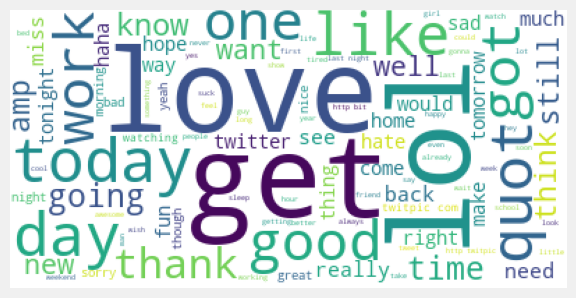

In [108]:
wordcloud= WordCloud(background_color='white',
                     stopwords=[],
                     max_words=100).generate(" ".join(corpus_ech))
                     
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

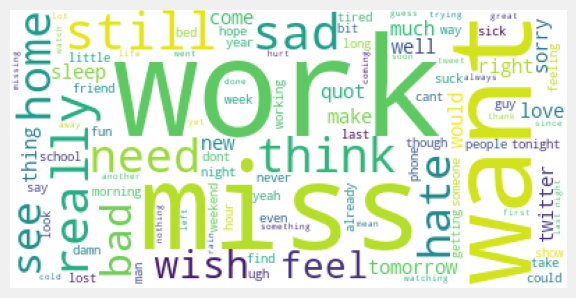

In [109]:
wordcloud= WordCloud(background_color='white',
                     stopwords=[],
                     max_words=100).generate(" ".join(corpus_ech_0))
                     
plt.imshow(wordcloud)
plt.axis("off")
plt.show();
              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084 entries, 0 to 6083
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mots    6084 non-null   object
 1   qte     6084 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 95.2+ KB


Text(0.5, 0, 'Mots')

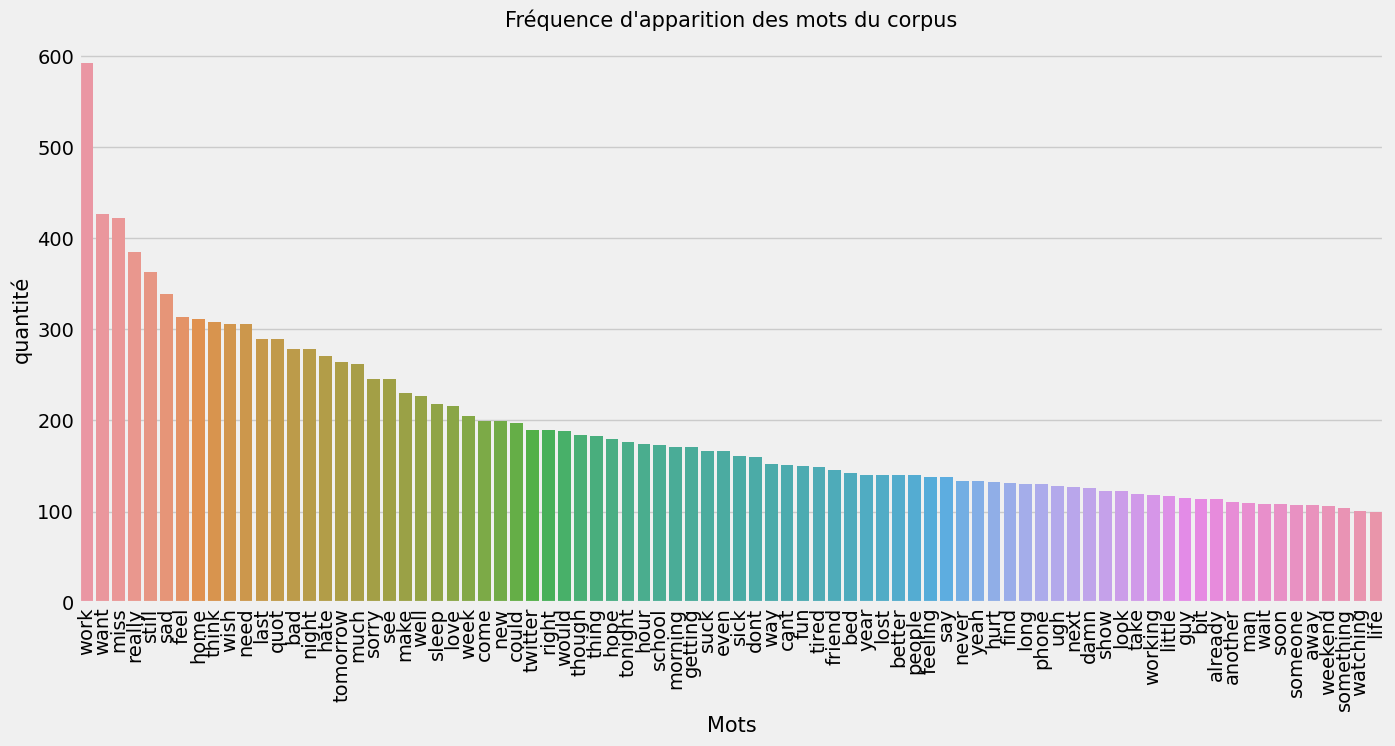

In [110]:
tmp=pd.Series(corpus_ech_0).value_counts()
tmp2=pd.DataFrame(tmp)
tmp2.reset_index(inplace=True)
tmp2.columns = ['mots','qte']
tmp2.info()

df_tmp2=tmp2.loc[tmp2['qte']>=100]
plt.figure(figsize=(15,7)) #taille de la fenetre pour le barplot
plt.xticks(rotation=90)#Rotation de 90°de l'axe des abscisses
sns.barplot(data=df_tmp2, x='mots', y='qte')#Création du barplot
plt.title("Fréquence d'apparition des mots du corpus",fontsize=15)
plt.ylabel("quantité", fontsize=15) #Titre de l'axe des ordonnées en taille 10
plt.xlabel("Mots", fontsize=15) #Titre de l'axe des abscisses en taille 10

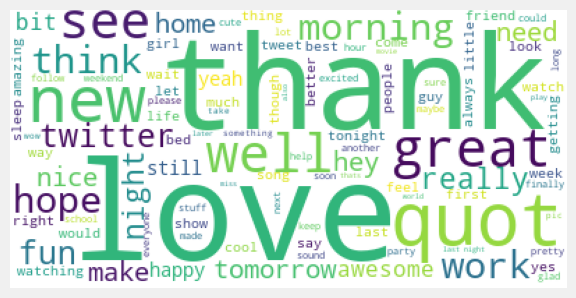

In [111]:
wordcloud= WordCloud(background_color='white',
                     stopwords=[],
                     max_words=100).generate(" ".join(corpus_ech_1))
                     
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6333 entries, 0 to 6332
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mots    6333 non-null   object
 1   qte     6333 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.1+ KB


Text(0.5, 0, 'Mots')

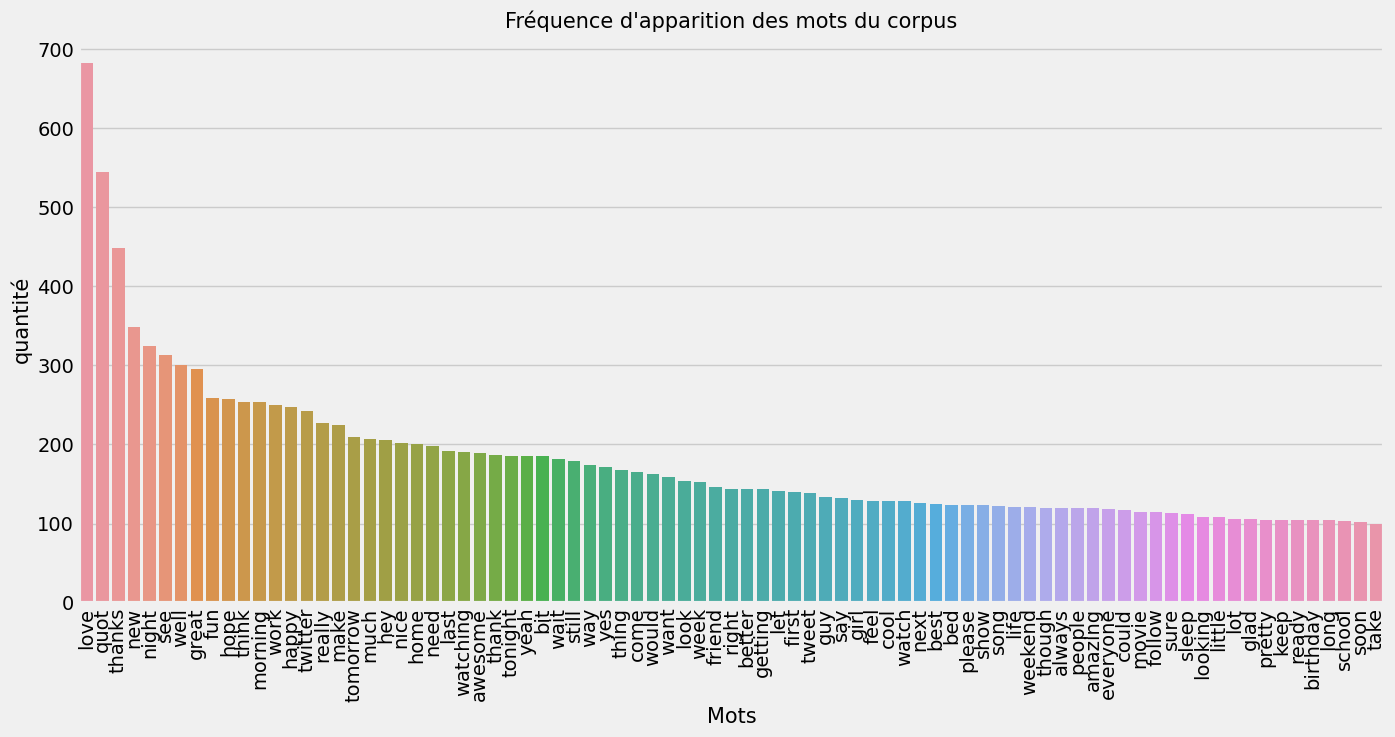

In [112]:
tmp=pd.Series(corpus_ech_1).value_counts()
tmp2=pd.DataFrame(tmp)
tmp2.reset_index(inplace=True)
tmp2.columns = ['mots','qte']
tmp2.info()

df_tmp2=tmp2.loc[tmp2['qte']>=100]
plt.figure(figsize=(15,7)) #taille de la fenetre pour le barplot
plt.xticks(rotation=90)#Rotation de 90°de l'axe des abscisses
sns.barplot(data=df_tmp2, x='mots', y='qte')#Création du barplot
plt.title("Fréquence d'apparition des mots du corpus",fontsize=15)
plt.ylabel("quantité", fontsize=15) #Titre de l'axe des ordonnées en taille 10
plt.xlabel("Mots", fontsize=15) #Titre de l'axe des abscisses en taille 10

### <a name="C523"> 5.2.3 Création des corpus par document</a> 

In [113]:
def final_clean_lem(doc) :
    
    #new_doc =process_text(doc,rejoin=True,lemm_or_stemm="stem",list_rare_words=list_min_5_words,eng_words=eng_words_stem,extra_words=doublons)
    new_doc =process_text(doc,rejoin=True,lemm_or_stemm="lem",min_len_words = 3,eng_words=eng_words_lem,stop_words=stop_words) # lem pour garde les mots en entier (contraitement à la stem qui ne garde que la racine des mots
    
    return new_doc

In [114]:
df_sentiment_ech["clean_text_lem"]=df_sentiment_ech.text.apply(final_clean_lem)

#from pandarallel import pandarallel # utilisation de tous les CPUs
#pandarallel.initialize(progress_bar=True)
#df_sentiment_ech["clean_text"]=df_sentiment_ech.text.parallel_apply(final_clean) #pour faire tourner le programme sur les X CPU
#df_sentiment_ech["clean_text"]=SeriesParallel(df_sentiment_ech.text, n_cores= 6, pbar = True).apply(final_clean)

df_sentiment_ech.head()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3496\1897160588.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp=pd.Series(cleaned_tokens_list).value_counts()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3496\1897160588.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp=pd.Series(cleaned_tokens_list).value_counts()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3496\1897160588.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp=pd.Series(cleaned_tokens_list).value_counts()


,target,text,clean_text_lem
0,0,@VARSITYFC guys I got so excited because I'm going with my church group on the 26th to six flags and I was like omg perfect! Man,varsityfc guy got excited going church group six flag like omg perfect man
1,0,"@benjorg Benny, when is AFS gonna start touring again!? I miss all of you!!",benjorg benny afs gonna start touring miss
2,0,@RobertsEmma Loooong way to go before that happens,robertsemma loooong way happens
3,0,it's so cold! [i don't wanna go to school!],cold wanna school
4,0,soooo nice outt wish i was seein my lovess day26 at summerjam whtev hotjam was insanee nd brian lovess me so does drake soo BYE!! lmfao,soooo nice outt wish seein love summerjam whtev hotjam insanee brian love drake soo bye lmfao


In [115]:
def final_clean_stem(doc) :
    
    #new_doc =process_text(doc,rejoin=True,lemm_or_stemm="stem",list_rare_words=list_min_5_words,eng_words=eng_words_stem,extra_words=doublons)
    new_doc =process_text(doc,rejoin=True,lemm_or_stemm="stem",min_len_words = 3,eng_words=eng_words_stem,stop_words=stop_words) # lem pour garde les mots en entier (contraitement à la stem qui ne garde que la racine des mots
    
    return new_doc

In [116]:
df_sentiment_ech["clean_text_stem"]=df_sentiment_ech.text.apply(final_clean_stem)

df_sentiment_ech.head()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3496\1897160588.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp=pd.Series(cleaned_tokens_list).value_counts()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3496\1897160588.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp=pd.Series(cleaned_tokens_list).value_counts()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3496\1897160588.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp=pd.Series(cleaned_tokens_list).value_counts()


,target,text,clean_text_lem,clean_text_stem
0,0,@VARSITYFC guys I got so excited because I'm going with my church group on the 26th to six flags and I was like omg perfect! Man,varsityfc guy got excited going church group six flag like omg perfect man,varsityfc guy got excit go church group six flag like omg perfect man
1,0,"@benjorg Benny, when is AFS gonna start touring again!? I miss all of you!!",benjorg benny afs gonna start touring miss,benjorg benni af gonna start tour miss
2,0,@RobertsEmma Loooong way to go before that happens,robertsemma loooong way happens,robertsemma loooong way happen
3,0,it's so cold! [i don't wanna go to school!],cold wanna school,cold wanna school
4,0,soooo nice outt wish i was seein my lovess day26 at summerjam whtev hotjam was insanee nd brian lovess me so does drake soo BYE!! lmfao,soooo nice outt wish seein love summerjam whtev hotjam insanee brian love drake soo bye lmfao,soooo nice outt wish seein lovess summerjam whtev hotjam insane brian lovess drake soo bye lmfao


In [117]:
import openpyxl
#Sauvegarde sous Excel
file_name = 'df_sentiment_ech.csv'

# saving the excelsheet
df_sentiment_ech.to_csv(file_name)
print('Fichier enregistré')

Fichier enregistré


## <a name="C53"> 5.3 Création des jeux d'entrainement, validation et test</a> 

In [118]:
t1=df_sentiment_ech.target #Mise en place de t1 pour le paramètre stratifiy dans le but d'avoir le même nombre de target 0 et 1 dans chaque split
# Séparation du jeu de données en jeu de test et entrainement/validation
X_train_valid, X_test, y_train_valid, y_test = train_test_split(df_sentiment_ech[["clean_text_lem","clean_text_stem"]], df_sentiment_ech["target"], test_size=0.2, random_state=55, stratify=t1)

# transformation de y_train_valid de Series en dataframe
y_train_valid=pd.DataFrame(y_train_valid)
y_train_valid.head()

t2=y_train_valid.target #Mise en place de t1 pour le paramètre stratifiy dans le but d'avoir le même nombre de target 0 et 1 dans chaque split
# Séparation du jeu d'entrainement/validation en jeux d'entrainement et en jeu de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid[["clean_text_lem","clean_text_stem"]], y_train_valid["target"], test_size=0.2, random_state=55, stratify=t2)

In [119]:
#X_train=pd.DataFrame(X_train)
#X_test=pd.DataFrame(X_test)
#X_valid=pd.DataFrame(X_valid)
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)
y_valid=pd.DataFrame(y_valid)

In [120]:
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12800 entries, 4323 to 13867
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clean_text_lem   12800 non-null  object
 1   clean_text_stem  12800 non-null  object
dtypes: object(2)
memory usage: 300.0+ KB


,clean_text_lem,clean_text_stem
4323,candeo tech amp related product day need much attention time fun,candeo tech amp relat product day need much attent time fun
10634,mxmarsh rat knew sent proposal,mxmarsh rat knew sent propos
16573,first day june one day closer summer,first day june one day closer summer
16452,changed username,chang usernam
13616,colorblindfish wait see kind guitar magic bring tour,colorblindfish wait see kind guitar magic bring tour


In [121]:
y_train.info()
y_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12800 entries, 4323 to 13867
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  12800 non-null  int64
dtypes: int64(1)
memory usage: 200.0 KB


,target
4323,0
10634,1
16573,1
16452,1
13616,1


0    6400
1    6400
Name: target, dtype: int64
0    0.5
1    0.5
Name: target, dtype: float64


<AxesSubplot: ylabel='target'>

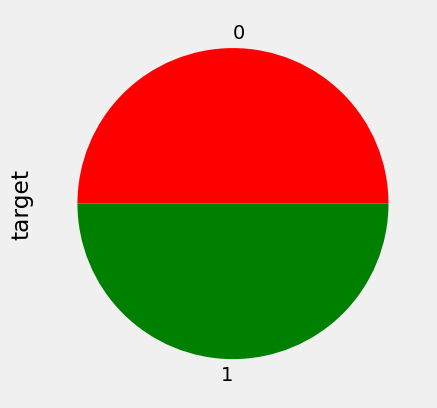

In [122]:
print(y_train["target"].value_counts())
print(y_train["target"].value_counts(normalize=True))
colors = ({"red":'red',"green": 'green'})
y_train.target.value_counts().plot(kind="pie", colors=colors)

In [123]:
X_test.info()
X_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 14072 to 16242
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clean_text_lem   4000 non-null   object
 1   clean_text_stem  4000 non-null   object
dtypes: object(2)
memory usage: 93.8+ KB


,clean_text_lem,clean_text_stem
14072,talking lady courier press,talk ladi courier press
1306,piano time amp work probably staying home tonight,piano time amp work probabl stay home tonight
3341,wait,wait
12784,hdmclachlan fair nuff hope get chance someday listen aforementioned track,hdmclachlan fair nuff hope get chanc someday listen aforement track
6333,boob sore,boob sore


In [124]:
y_test.info()
y_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 14072 to 16242
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  4000 non-null   int64
dtypes: int64(1)
memory usage: 62.5 KB


,target
14072,1
1306,0
3341,0
12784,1
6333,0


1    2000
0    2000
Name: target, dtype: int64
1    0.5
0    0.5
Name: target, dtype: float64


<AxesSubplot: ylabel='target'>

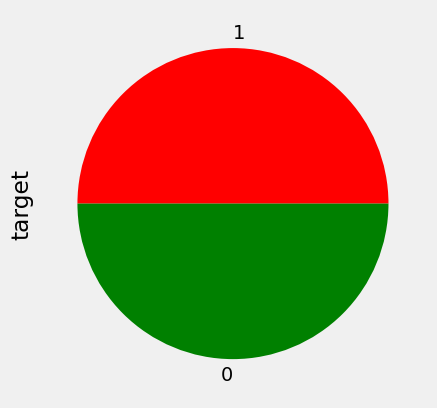

In [125]:
print(y_test["target"].value_counts())
print(y_test["target"].value_counts(normalize=True))
colors = ({"red":'red',"green": 'green'})
y_test.target.value_counts().plot(kind="pie", colors=colors)

In [126]:
X_valid.info()
X_valid.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 3014 to 14618
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clean_text_lem   3200 non-null   object
 1   clean_text_stem  3200 non-null   object
dtypes: object(2)
memory usage: 75.0+ KB


,clean_text_lem,clean_text_stem
3014,wish home place like home,wish home place like home
17365,pancake coffee wanting play golf,pancak coffe want play golf
8324,yes well,ye well
19961,thanks,thank
10241,startonomics perhaps guy would extremist controlled pak,startonom perhap guy would extremist control pak


In [127]:
y_valid.info()
y_valid.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 3014 to 14618
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  3200 non-null   int64
dtypes: int64(1)
memory usage: 50.0 KB


,target
3014,0
17365,1
8324,0
19961,1
10241,1


0    1600
1    1600
Name: target, dtype: int64
0    0.5
1    0.5
Name: target, dtype: float64


<AxesSubplot: ylabel='target'>

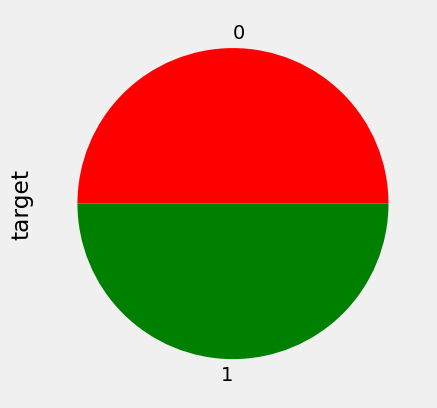

In [128]:
print(y_valid["target"].value_counts())
print(y_valid["target"].value_counts(normalize=True))
colors = ({"red":'red',"green": 'green'})
y_valid.target.value_counts().plot(kind="pie", colors=colors)

In [129]:
#Sauvegarde sous Excel 
X_train.to_excel('X_train_ech.xlsx',index=False)
y_train.to_excel('y_train_ech.xlsx',index=False)

X_test.to_excel('X_test_ech.xlsx',index=False)
y_test.to_excel('y_test_ech.xlsx',index=False)

X_valid.to_excel('X_valid_ech.xlsx',index=False)
y_valid.to_excel('y_valid_ech.xlsx',index=False)


In [130]:
#STOP

# <a name="C6"> 6 Extraction des features</a> 

In [131]:
#STOP

## <a name="C61"> 6.1 Bag of Words</a> 

### <a name="C611"> 6.1.1 Visualisation de résultats</a> 

In [132]:
def cv(data, ngram = 1, MAX_NB_WORDS = 75000):
    count_vectorizer = CountVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = count_vectorizer.fit_transform(data).toarray()
    print("count vectorize with", str(np.array(emb).shape[1]), "features")
    return emb, count_vectorizer

In [133]:
test_corpus = df_sentiment_ech["clean_text_lem"][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_cv_em_1gram, test_cv_1gram = cv(test_corpus, ngram=1)
affichage_features(test_cv_em_1gram, test_cv_1gram, ngram="Uni-gram")

The test corpus:  ['varsityfc guy got excited going church group six flag like omg perfect man', 'benjorg benny afs gonna start touring miss', 'robertsemma loooong way happens', 'cold wanna school', 'soooo nice outt wish seein love summerjam whtev hotjam insanee brian love drake soo bye lmfao'] 

count vectorize with 42 features
Uni-gram bag-of-words: 
['afs' 'benjorg' 'benny' 'brian' 'bye' 'church' 'cold' 'drake' 'excited'
 'flag' 'going' 'gonna' 'got' 'group' 'guy' 'happens' 'hotjam' 'insanee'
 'like' 'lmfao' 'loooong' 'love' 'man' 'miss' 'nice' 'omg' 'outt'
 'perfect' 'robertsemma' 'school' 'seein' 'six' 'soo' 'soooo' 'start'
 'summerjam' 'touring' 'varsityfc' 'wanna' 'way' 'whtev' 'wish'] 

Uni-gram bag-of-feature: 
{'varsityfc': 37, 'guy': 14, 'got': 12, 'excited': 8, 'going': 10, 'church': 5, 'group': 13, 'six': 31, 'flag': 9, 'like': 18, 'omg': 25, 'perfect': 27, 'man': 22, 'benjorg': 1, 'benny': 2, 'afs': 0, 'gonna': 11, 'start': 34, 'touring': 36, 'miss': 23, 'robertsemma': 28

In [134]:
# test en bigram
test_cv_em_2gram, test_cv_2gram = cv(test_corpus, ngram=2)
affichage_features(test_cv_em_2gram, test_cv_2gram, ngram="Bi-gram")

count vectorize with 38 features
Bi-gram bag-of-words: 
['afs gonna' 'benjorg benny' 'benny afs' 'brian love' 'bye lmfao'
 'church group' 'cold wanna' 'drake soo' 'excited going' 'flag like'
 'going church' 'gonna start' 'got excited' 'group six' 'guy got'
 'hotjam insanee' 'insanee brian' 'like omg' 'loooong way' 'love drake'
 'love summerjam' 'nice outt' 'omg perfect' 'outt wish' 'perfect man'
 'robertsemma loooong' 'seein love' 'six flag' 'soo bye' 'soooo nice'
 'start touring' 'summerjam whtev' 'touring miss' 'varsityfc guy'
 'wanna school' 'way happens' 'whtev hotjam' 'wish seein'] 

Bi-gram bag-of-feature: 
{'varsityfc': 37, 'guy': 14, 'got': 12, 'excited': 8, 'going': 10, 'church': 5, 'group': 13, 'six': 31, 'flag': 9, 'like': 18, 'omg': 25, 'perfect': 27, 'man': 22, 'benjorg': 1, 'benny': 2, 'afs': 0, 'gonna': 11, 'start': 34, 'touring': 36, 'miss': 23, 'robertsemma': 28, 'loooong': 20, 'way': 39, 'happens': 15, 'cold': 6, 'wanna': 38, 'school': 29, 'soooo': 33, 'nice': 24, 'ou

In [135]:
# tri-gram
test_cv_em_3gram, test_cv_3gram = cv(test_corpus, ngram=3)
affichage_features(test_cv_em_3gram, test_cv_3gram, ngram="Tri-gram")

count vectorize with 33 features
Tri-gram bag-of-words: 
['afs gonna start' 'benjorg benny afs' 'benny afs gonna'
 'brian love drake' 'church group six' 'cold wanna school' 'drake soo bye'
 'excited going church' 'flag like omg' 'going church group'
 'gonna start touring' 'got excited going' 'group six flag'
 'guy got excited' 'hotjam insanee brian' 'insanee brian love'
 'like omg perfect' 'loooong way happens' 'love drake soo'
 'love summerjam whtev' 'nice outt wish' 'omg perfect man'
 'outt wish seein' 'robertsemma loooong way' 'seein love summerjam'
 'six flag like' 'soo bye lmfao' 'soooo nice outt' 'start touring miss'
 'summerjam whtev hotjam' 'varsityfc guy got' 'whtev hotjam insanee'
 'wish seein love'] 

Tri-gram bag-of-feature: 
{'varsityfc': 37, 'guy': 14, 'got': 12, 'excited': 8, 'going': 10, 'church': 5, 'group': 13, 'six': 31, 'flag': 9, 'like': 18, 'omg': 25, 'perfect': 27, 'man': 22, 'benjorg': 1, 'benny': 2, 'afs': 0, 'gonna': 11, 'start': 34, 'touring': 36, 'miss': 23,

In [136]:
# implémentation sur tout le dataset
train_df_corpus = df_sentiment_ech["clean_text_lem"].tolist()
train_df_em_1gram, vc_1gram = cv(train_df_corpus, 1)
#train_df_em_2gram, vc_2gram = cv(train_df_corpus, 2) #Mise en commentaire car le jeu de données (20000 Tweets) est devenu trop important à gérer en terme de mémoire Unable to allocate 11.2 GiB for an array with shape (20000, 75000) and data type int64
#train_df_em_3gram, vc_3gram = cv(train_df_corpus, 3) #Mise en commentaire car le jeu de données (20000 Tweets) est devenu trop important à gérer en terme de mémoire Unable to allocate 11.2 GiB for an array with shape (20000, 75000) and data type int64

print(len(train_df_corpus))
print(train_df_em_1gram.shape)
#print(train_df_em_2gram.shape)
#print(train_df_em_3gram.shape)

count vectorize with 25053 features
20000
(20000, 25053)


In [137]:
# Suppression des dataframes, on ne garde que vc_xgram
del train_df_em_1gram#, train_df_em_2gram#, train_df_em_3gram

### <a name="C612"> 6.1.2 Application sur le corpus</a> 

In [138]:
count_vectorizer = CountVectorizer()
X_train_vector = count_vectorizer.fit_transform(X_train['clean_text_lem'])
X_test_vector = count_vectorizer.transform(X_test['clean_text_lem'])
X_valid_vector = count_vectorizer.transform(X_valid['clean_text_lem'])

print(X_train_vector[0].todense()) #todense pour créer une matrice

#X_train_vector = X_train_vector.todense()
#X_test_vector = X_test_vector.todense()
#X_valid_vector = X_valid_vector.todense()

[[0 0 0 ... 0 0 0]]


## <a name="C6.2"> 6.2 Term Frequency-Inverse Document Frequency (TF-IDF)</a> 

### <a name="C621"> 6.2.1 Visualisation de résultats</a> 

In [139]:
def TFIDF(data, ngram = 1, MAX_NB_WORDS = 75000):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

In [140]:
test_corpus = df_sentiment_ech["clean_text_lem"][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_tfidf_em_1gram, test_tfidf_1gram = TFIDF(test_corpus, ngram=1)
affichage_features(test_tfidf_em_1gram, test_tfidf_1gram, ngram="Uni-gram")

The test corpus:  ['varsityfc guy got excited going church group six flag like omg perfect man', 'benjorg benny afs gonna start touring miss', 'robertsemma loooong way happens', 'cold wanna school', 'soooo nice outt wish seein love summerjam whtev hotjam insanee brian love drake soo bye lmfao'] 

tf-idf with 42 features
Uni-gram bag-of-words: 
['afs' 'benjorg' 'benny' 'brian' 'bye' 'church' 'cold' 'drake' 'excited'
 'flag' 'going' 'gonna' 'got' 'group' 'guy' 'happens' 'hotjam' 'insanee'
 'like' 'lmfao' 'loooong' 'love' 'man' 'miss' 'nice' 'omg' 'outt'
 'perfect' 'robertsemma' 'school' 'seein' 'six' 'soo' 'soooo' 'start'
 'summerjam' 'touring' 'varsityfc' 'wanna' 'way' 'whtev' 'wish'] 

Uni-gram bag-of-feature: 
{'varsityfc': 37, 'guy': 14, 'got': 12, 'excited': 8, 'going': 10, 'church': 5, 'group': 13, 'six': 31, 'flag': 9, 'like': 18, 'omg': 25, 'perfect': 27, 'man': 22, 'benjorg': 1, 'benny': 2, 'afs': 0, 'gonna': 11, 'start': 34, 'touring': 36, 'miss': 23, 'robertsemma': 28, 'loooon

In [141]:
test_tfidf_em_2gram, test_tfidf_2gram = TFIDF(test_corpus, ngram=2)
affichage_features(test_tfidf_em_2gram, test_tfidf_2gram, ngram="Bi-gram")

tf-idf with 38 features
Bi-gram bag-of-words: 
['afs gonna' 'benjorg benny' 'benny afs' 'brian love' 'bye lmfao'
 'church group' 'cold wanna' 'drake soo' 'excited going' 'flag like'
 'going church' 'gonna start' 'got excited' 'group six' 'guy got'
 'hotjam insanee' 'insanee brian' 'like omg' 'loooong way' 'love drake'
 'love summerjam' 'nice outt' 'omg perfect' 'outt wish' 'perfect man'
 'robertsemma loooong' 'seein love' 'six flag' 'soo bye' 'soooo nice'
 'start touring' 'summerjam whtev' 'touring miss' 'varsityfc guy'
 'wanna school' 'way happens' 'whtev hotjam' 'wish seein'] 

Bi-gram bag-of-feature: 
{'varsityfc': 37, 'guy': 14, 'got': 12, 'excited': 8, 'going': 10, 'church': 5, 'group': 13, 'six': 31, 'flag': 9, 'like': 18, 'omg': 25, 'perfect': 27, 'man': 22, 'benjorg': 1, 'benny': 2, 'afs': 0, 'gonna': 11, 'start': 34, 'touring': 36, 'miss': 23, 'robertsemma': 28, 'loooong': 20, 'way': 39, 'happens': 15, 'cold': 6, 'wanna': 38, 'school': 29, 'soooo': 33, 'nice': 24, 'outt': 26, 

In [142]:
test_tfidf_em_3gram, test_tfidf_3gram = TFIDF(test_corpus, ngram=3)
affichage_features(test_tfidf_em_3gram, test_tfidf_3gram, ngram="Tri-gram")

tf-idf with 33 features
Tri-gram bag-of-words: 
['afs gonna start' 'benjorg benny afs' 'benny afs gonna'
 'brian love drake' 'church group six' 'cold wanna school' 'drake soo bye'
 'excited going church' 'flag like omg' 'going church group'
 'gonna start touring' 'got excited going' 'group six flag'
 'guy got excited' 'hotjam insanee brian' 'insanee brian love'
 'like omg perfect' 'loooong way happens' 'love drake soo'
 'love summerjam whtev' 'nice outt wish' 'omg perfect man'
 'outt wish seein' 'robertsemma loooong way' 'seein love summerjam'
 'six flag like' 'soo bye lmfao' 'soooo nice outt' 'start touring miss'
 'summerjam whtev hotjam' 'varsityfc guy got' 'whtev hotjam insanee'
 'wish seein love'] 

Tri-gram bag-of-feature: 
{'varsityfc': 37, 'guy': 14, 'got': 12, 'excited': 8, 'going': 10, 'church': 5, 'group': 13, 'six': 31, 'flag': 9, 'like': 18, 'omg': 25, 'perfect': 27, 'man': 22, 'benjorg': 1, 'benny': 2, 'afs': 0, 'gonna': 11, 'start': 34, 'touring': 36, 'miss': 23, 'roberts

In [143]:
# implémentation sur tout le dataset
train_df_corpus = df_sentiment_ech["clean_text_lem"].tolist()
train_df_tfidf_1gram, tfidf_1gram = TFIDF(train_df_corpus, 1)
#train_df_tfidf_2gram, tfidf_2gram = TFIDF(train_df_corpus, 2)
#train_df_tfidf_3gram, tfidf_3gram = TFIDF(train_df_corpus, 3) # mise en commentaire du bi/trigram car gestion mémoire KO avec 20 000 tweets Unable to allocate 11.2 GiB for an array with shape (20000, 75000) and data type float64

print(len(train_df_corpus))
print(train_df_tfidf_1gram.shape)
#print(train_df_tfidf_2gram.shape)
#print(train_df_tfidf_3gram.shape)

tf-idf with 25053 features
20000
(20000, 25053)


In [144]:
del train_df_tfidf_1gram#, train_df_tfidf_2gram#, train_df_tfidf_3gram

### <a name="C622">6.2.2 Application sur le corpus</a> 

In [145]:
tfidf = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
X_train_tfidf = tfidf.fit_transform(X_train['clean_text_lem'])
X_test_tfidf = tfidf.transform(X_test['clean_text_lem'])
X_valid_tfidf = tfidf.transform(X_valid['clean_text_lem'])

## <a name="C63"> 6.3 Word embedding</a> 

### <a name="C631"> 6.3.1 Word2vec</a> 

#### <a name="C6311"> 6.3.1.1 Visualisation de résultats</a> 

In [146]:
word2vec_path = "GoogleNews-vectors-negative300.bin"

# chargement de 200 000 mot les plus utilisé dans les information du Corpus Google
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 

In [147]:
print(word2vec_model.similarity('cat', 'kitten'))
print(word2vec_model.similarity('cat', 'cats'))

0.74649847
0.8099379


In [148]:
def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
    """
        Calculate average embedding value of sentence from each word vector
    """
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_embeddings(vectors, text, generate_missing=False, k=300):
    """
        create the sentence embedding
    """
    embeddings = text.apply(lambda x: get_average_vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [149]:
embeddings_word2vec = get_embeddings(word2vec_model, df_sentiment_ech["clean_text_lem"], k=300)

print("Embedding matrix size", len(embeddings_word2vec), len(embeddings_word2vec[0]))
print("The sentence: \"%s\" got embedding values: " % df_sentiment_ech["clean_text_lem"][0])
print(embeddings_word2vec[0])

Embedding matrix size 20000 300
The sentence: "varsityfc guy got excited going church group six flag like omg perfect man" got embedding values: 
[-0.16203844  0.07337498  0.0265107   0.10729651 -0.0427011   0.0089099
 -0.07968387 -0.04624815 -0.03616415  0.01338897 -0.05010301 -0.07896959
 -0.18431627  0.04303143 -0.09570312  0.07813325  0.03716051  0.16557353
 -0.04025598 -0.01403602 -0.21200314 -0.03301631  0.06688804  0.00350308
 -0.05485267  0.02311873 -0.24155735  0.04934362 -0.02352493 -0.02876323
  0.01002296  0.01526394 -0.02736272 -0.08807208 -0.13469634  0.08016885
 -0.19062393  0.10835225 -0.0595382   0.07663624 -0.01683828 -0.02374597
  0.07346983  0.09269673  0.03101833 -0.01500346 -0.00879154 -0.13338656
 -0.06493481  0.04470908 -0.12682941  0.18663561 -0.03669038  0.19156296
  0.05092889  0.09185461 -0.13050636 -0.1048519  -0.0238334  -0.12975084
 -0.10525657 -0.05747285 -0.17412588 -0.03637463 -0.00951478 -0.19587006
 -0.08255046  0.08928619 -0.04835964  0.02115281  0.

In [150]:
del embeddings_word2vec

#### <a name="C6312"> 6.3.1.2 Application sur le corpus</a> 

In [151]:
X_train_word2vec = get_embeddings(word2vec_model, X_train['clean_text_lem'], k=300)
X_test_word2vec = get_embeddings(word2vec_model, X_test['clean_text_lem'], k=300)
X_valid_word2vec = get_embeddings(word2vec_model, X_valid['clean_text_lem'], k=300)


X_train_word2vec = np.asarray(X_train_word2vec)
X_test_word2vec = np.asarray(X_test_word2vec)
X_valid_word2vec = np.asarray(X_valid_word2vec)

### <a name="C632"> 6.3.2 Global Vectors for Word Representation (GloVe)</a> 

#### <a name="C6321"> 6.3.2.1 Visualisation de résultats</a> 

In [152]:
glove_input_file = "glove.6B.300d.txt"
word2vec_output_file = "glove.6B.300d.txt.word2vec"

In [153]:
glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [154]:
#glove2word2vec(glove_input_file, word2vec_output_file)
# we only load 200k most common words from Google New corpus 
#glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False, limit=200000) #

In [155]:
print(glove_model.similarity('cat', 'kitten'))
print(glove_model.similarity('cat', 'cats'))

0.43046176
0.68158364


In [156]:
embeddings_glove = get_embeddings(glove_model, df_sentiment_ech["clean_text_lem"], k=300)

print("Embedding matrix size", len(embeddings_glove), len(embeddings_glove[0]))
print("The sentence: \"%s\" got embedding values: " % df_sentiment_ech["clean_text_lem"][0])
print(embeddings_glove[0])

Embedding matrix size 20000 300
The sentence: "varsityfc guy got excited going church group six flag like omg perfect man" got embedding values: 
[-2.04043117e-01  2.49811382e-02 -2.04532567e-01 -5.01071887e-02
 -5.85310676e-01  8.09845291e-02 -1.85389208e-03  2.01266943e-01
 -3.11473377e-01 -8.78124998e-01  8.34103621e-02  1.45601503e-02
 -3.26221823e-01  1.09600916e-01 -1.15153861e-01 -1.41883954e-01
 -2.29214192e-01  2.67664446e-01  1.74331488e-01 -9.76959490e-02
 -4.97533396e-02 -1.20503337e-01 -2.35110276e-02  2.61707029e-02
 -3.30669765e-02  1.51915769e-01  1.52603660e-01  1.07251793e-01
  2.21484220e-01 -3.21243360e-01 -1.32043807e-01  3.30552862e-01
 -2.27287553e-01 -1.18879029e-01 -5.84522159e-01 -8.63778332e-03
  2.77853687e-01 -3.82678177e-01 -1.66409297e-01  2.03274662e-01
 -1.24168851e-01 -2.06100585e-02 -4.53099088e-01  4.47978799e-01
 -2.59651286e-01 -2.33451921e-01  1.57075208e-01 -1.10492093e-01
  6.21131623e-02  2.07809483e-02  6.13409482e-03  1.63936538e-01
 -8.54770

In [157]:
del embeddings_glove

#### <a name="C6322"> 6.3.2.2 Application sur le corpus</a> 

In [158]:
X_train_glove = get_embeddings(glove_model, X_train['clean_text_lem'], k=300)
X_test_glove = get_embeddings(glove_model, X_test['clean_text_lem'], k=300)
X_valid_glove = get_embeddings(glove_model, X_valid['clean_text_lem'], k=300)


X_train_glove = np.asarray(X_train_glove)
X_test_glove = np.asarray(X_test_glove)
X_valid_glove = np.asarray(X_valid_glove)


### <a name="C6.3.3"> 6.3.3 FastText</a> 

#### <a name="C6331"> 6.3.3.1 Visualisation de résultats</a> 

In [159]:
fasttext_path = "wiki-news-300d-1M.vec"
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False, limit=200000)

In [160]:
print(fasttext_model.similarity('cat', 'kitten'))
print(fasttext_model.similarity('cat', 'cats'))

0.7353649
0.85528094


In [161]:
embeddings_fasttext = get_embeddings(fasttext_model, df_sentiment_ech["clean_text_lem"], k=300)

print("Embedding matrix size", len(embeddings_fasttext), len(embeddings_fasttext[0]))
print("The sentence: \"%s\" got embedding values: " % df_sentiment_ech["clean_text_lem"][0])
print(embeddings_fasttext[0])

Embedding matrix size 20000 300
The sentence: "varsityfc guy got excited going church group six flag like omg perfect man" got embedding values: 
[-8.65743245e-02  3.05608105e-02 -8.09405388e-02 -2.75054059e-02
  3.11891897e-02  2.94662163e-02  9.41081154e-03 -3.82621626e-02
  1.23747297e-01  3.86283778e-02 -1.25040539e-02 -5.59216210e-02
  2.51081078e-02 -2.58108110e-02 -4.70500008e-02  4.34608115e-02
 -2.17297291e-02 -3.21959460e-02 -3.07283777e-02  7.60256737e-02
 -1.11445944e-02 -1.30006758e-01 -3.01662166e-02 -2.46540540e-02
 -8.34081083e-02 -7.15243253e-02  2.07162164e-02  1.63024323e-01
  3.12608117e-02 -9.07135132e-02  5.07108114e-02  2.92499990e-02
  1.34202710e-02 -2.27702702e-02  5.25378373e-02  5.16527021e-02
 -2.28108099e-03  4.26999996e-02  7.68891893e-02 -1.92891900e-02
 -1.51621622e-02  1.65364867e-02 -8.35527021e-02  1.55945951e-02
  1.92418922e-02  1.14554062e-02  2.01851357e-02  3.06135129e-02
  9.98648652e-02 -3.46486457e-03 -3.73959456e-02 -6.80432427e-02
 -5.78441

In [162]:
del embeddings_fasttext

#### <a name="C6332"> 6.3.3.2 Application sur le corpus</a> 

In [163]:
X_train_fasttext = get_embeddings(fasttext_model, X_train['clean_text_lem'], k=300)
X_test_fasttext = get_embeddings(fasttext_model, X_test['clean_text_lem'], k=300)
X_valid_fasttext = get_embeddings(fasttext_model, X_valid['clean_text_lem'], k=300)

X_train_fasttext  = np.asarray(X_train_fasttext)
X_test_fasttext  = np.asarray(X_test_fasttext)
X_valid_fasttext  = np.asarray(X_valid_fasttext)

### <a name="C634"> 6.3.4 Bidirectional Encoder Representations from Transformers (BERT)</a> 

In [164]:
'''BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters
BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters
BERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters
BERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters
BERT-Base, Multilingual Case: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters
BERT-Base, Chinese: Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters'''

'BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters\nBERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters\nBERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters\nBERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters\nBERT-Base, Multilingual Case: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters\nBERT-Base, Chinese: Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters'

In [165]:


module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
#module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"

bert_layer = hub.KerasLayer(module_url, trainable=True)

In [166]:

'''3 encodages :
-tokens, Encodage hiérarchique classique, un mot = un chiffre
-pad_masks : Embedding de position pour exprimer l’emplacement des mots dans une phrase.
-segment_ids:  Embeddings de segments : BERT peut également prendre des paires de phrases comme entrées pour des tâches, notamment pour des modèle de Question-Réponse, ce ne sera pas notre cas ici, cette liste sera donc rempli de zéros'''



def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [167]:
'''On initialise le tokenizer en allant chercher dans le modèle BERT à la fois la liste de
vocabulaire et leur index / chiffre associé et la fonction pour passer les mots en lettres majuscules en minuscules.'''

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [168]:
#les phrases encodées pour BERT
X_train_bert = bert_encode(X_train.clean_text_lem.values, tokenizer, max_len=100)
X_test_bert = bert_encode(X_test.clean_text_lem.values, tokenizer, max_len=100)
X_valid_bert = bert_encode(X_valid.clean_text_lem.values, tokenizer, max_len=100)

#les labels sur lesquel BERT doit s’entraîner / prédire
y_train_bert = y_train.target.values
y_test_bert = y_test.target.values
y_valid_bert = y_valid.target.values

### <a name="C635"> 6.3.5 Universal Sentence Encoder (USE)</a> 

In [169]:
start_use_charging  = time.time()
    
# Load pre-trained universal sentence encoder model
embed_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

end_use_charging = time.time()
print("Le temps de chargement total (en minutes) du modèle pré-entrainé est :")
print((end_use_charging - start_use_charging)/60)

Le temps de chargement total (en minutes) du modèle pré-entrainé est :
0.11181354522705078


In [170]:
X_train.head()

,clean_text_lem,clean_text_stem
4323,candeo tech amp related product day need much attention time fun,candeo tech amp relat product day need much attent time fun
10634,mxmarsh rat knew sent proposal,mxmarsh rat knew sent propos
16573,first day june one day closer summer,first day june one day closer summer
16452,changed username,chang usernam
13616,colorblindfish wait see kind guitar magic bring tour,colorblindfish wait see kind guitar magic bring tour


In [171]:
# transformation des Tweets grace à Universal Sentence encoder
X_train_use = embed_use(X_train['clean_text_lem'])
X_test_use = embed_use(X_test['clean_text_lem'])
X_valid_use = embed_use(X_valid['clean_text_lem'])


X_train_use = np.asarray(X_train_use)
X_test_use = np.asarray(X_test_use)
X_valid_use  = np.asarray(X_valid_use)

print("embeddings_use_X_train",X_train_use)
print("embeddings_use_X_test :",X_test_use)
print("embeddings_use_X_valid :",X_valid_use)

embeddings_use_X_train [[ 0.00532129  0.03019154  0.05413578 ...  0.01457357 -0.07358345
   0.03981367]
 [ 0.00593381  0.0264682  -0.02025035 ... -0.00510227 -0.05751809
   0.02043575]
 [ 0.00315337 -0.07992319  0.04087159 ...  0.04818324 -0.06946069
   0.02789237]
 ...
 [ 0.00480495 -0.04936642 -0.04713743 ...  0.07097197 -0.06211255
  -0.07155759]
 [-0.00524972  0.00977581 -0.03157724 ... -0.01406844  0.041856
  -0.00811763]
 [-0.03623296  0.00514709 -0.02013222 ... -0.06354172 -0.03867318
   0.03091834]]
embeddings_use_X_test : [[ 2.45168172e-02  1.41448183e-02  6.00524154e-03 ... -3.68360952e-02
  -3.45484517e-03  2.93988902e-02]
 [-1.81204546e-02 -6.20542988e-02  8.32148790e-02 ... -7.42198853e-03
   3.23515125e-02  5.54699823e-02]
 [-1.80249512e-02 -4.36992198e-02  5.73695451e-02 ... -4.92512845e-02
   1.57094449e-02 -2.02890038e-02]
 ...
 [ 2.71364413e-02 -5.47497533e-02 -2.46446338e-02 ... -3.49916033e-02
   5.52122518e-02  3.48573662e-02]
 [-8.67007207e-03 -6.43179193e-02 -3.0

In [172]:
#Mise à jour de l'index de X train juste pour tester l'affichage
X_train2=X_train.copy()
X_train2.reset_index(inplace=True)


# Affichage des vecteurs crée grace à Universal Sentence encoder
for index in range(2):
    print(X_train2.loc[index,'clean_text_lem'])
    print(X_train_use[index])

candeo tech amp related product day need much attention time fun
[ 0.00532129  0.03019154  0.05413578 -0.01632391  0.02410255  0.02014486
  0.01341284  0.02030857  0.07821922  0.013945   -0.01164728  0.05392794
 -0.02268079 -0.04812276  0.0211203   0.01593658  0.045031   -0.03457809
  0.02720921 -0.05495381 -0.0440563  -0.00318819  0.03948463 -0.04105412
 -0.0801948   0.00305728 -0.06450433 -0.01221761 -0.04532326  0.00321741
 -0.00377334  0.06031975 -0.01057797 -0.01592592  0.04800346  0.08278896
 -0.02253175 -0.08983579  0.02031926 -0.02763999 -0.02579257  0.08122815
  0.0736541  -0.05032796  0.00073794  0.07497308 -0.01414401 -0.07254046
  0.0066336   0.04460701 -0.01334126 -0.01382478  0.01457097 -0.03997432
 -0.00672614 -0.05453022  0.04387619  0.00847619 -0.03275207  0.01663469
  0.00240762  0.01488298  0.04518001  0.01066526 -0.0540855   0.07558512
 -0.01148129 -0.02936179  0.04713222 -0.00041485  0.01641182 -0.08980059
 -0.03420738 -0.01318791 -0.02670917 -0.08836652  0.0440953

# <a name="C7"> 7 Modèles </a> 

In [173]:
STOP

NameError: name 'STOP' is not defined

## <a name="C71"> 7.1 Modèles sur mesure simples </a> 

### <a name="C711"> 7.1.1 XGB Classifier</a> 

In [ ]:
xgb_estimator = xgb.XGBClassifier()

xgb_parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb_grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=xgb_parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = StratifiedKFold(n_splits=10),
    verbose=True
)

#### <a name="C7111"> 7.1.1.1 Bag of Words</a> 

In [ ]:
calcul_modele(xgb_estimator,xgb_parameters,xgb_grid_search,X_train_vector,y_train['target'],X_test_vector,y_test["target"])

#### <a name="C7112"> 7.1.1.2 TF-IDF</a> 

In [ ]:
calcul_modele(xgb_estimator,xgb_parameters,xgb_grid_search,X_train_tfidf,y_train['target'],X_test_tfidf,y_test["target"])

### <a name="C712"> 7.1.2 MultiNomial Naive Bayes</a> 

In [ ]:
mnb_estimator = MultinomialNB()

mnb_parameters = {
    'alpha': [2,1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
}

mnb_grid_search = GridSearchCV(
    estimator=mnb_estimator,
    param_grid=mnb_parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv =StratifiedKFold(n_splits=10),
    verbose=True
)

#### <a name="C7121"> 7.1.2.1 Bag of Words</a> 

In [ ]:
calcul_modele(mnb_estimator,mnb_parameters,mnb_grid_search,X_train_vector,y_train['target'],X_test_vector,y_test["target"])

#### <a name="C7121"> 7.1.2.1 TF-IDF</a> 

In [ ]:
calcul_modele(mnb_estimator,mnb_parameters,mnb_grid_search,X_train_tfidf,y_train['target'],X_test_tfidf,y_test["target"])

### <a name="C713"> 7.1.3 Logistic Regression</a> 

In [ ]:
lr_estimator = LogisticRegression()

lr_parameters ={
    'C' : np.logspace(-3,3,7), 
    'penalty':['I1','l2'], 
    'solver' : ['newton-cholesky', 'sag', 'liblinear', 'saga', 'lbfgs', 'newton-cg']
}

lr_grid_search = GridSearchCV(
    estimator=lr_estimator,
    param_grid=lr_parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv =StratifiedKFold(n_splits=10),
    verbose=True
)

#### <a name="C7131"> 7.1.3.1 Bag of Words</a> 

In [ ]:
calcul_modele(lr_estimator,lr_parameters,lr_grid_search,X_train_vector,y_train['target'],X_test_vector,y_test["target"])

#### <a name="C7132"> 7.1.3.2 TF-IDF</a> 

In [ ]:
calcul_modele(lr_estimator,lr_parameters,lr_grid_search,X_train_tfidf,y_train['target'],X_test_tfidf,y_test["target"])

## <a name="C72"> 7.2 Modèles sur mesure complexe</a> 

### <a name="C721"> 7.2.1 RNN : Simple RNN, LSTM et GRU</a> 

In [199]:
def build_model(nb_words, rnn_model="SimpleRNN", embedding_matrix=None): #="SimpleRNN"
    '''
    build_model function:
    inputs: 
        rnn_model - Choisir la couche de RNN à utiliser (SimpleRNN, LSTM, GRU)
        embedding_matrix - permet de choisir d'utiliser ou non un embedding pré-entrainé ou non 
    '''
    model = Sequential()
    # ajout de la couche embedding
    if embedding_matrix is not None:
        model.add(Embedding(nb_words, 
                        200, 
                        weights=[embedding_matrix], 
                        input_length= max_len,
                        trainable = False))
    else:
        model.add(Embedding(nb_words, 
                        200, 
                        input_length= max_len,
                        trainable = False))
        
    # ajout de la couche RNN choisie
    if rnn_model == "SimpleRNN":
        model.add(SimpleRNN(200))
    elif rnn_model == "LSTM":
        model.add(LSTM(200))
    else:
        model.add(GRU(200))
    #model.add(Dense(500,activation='relu'))
    #model.add(Dense(500, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    #model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', 
                optimizer='adam',
                metrics=['accuracy', 'AUC'])
    return model

In [200]:
def score_rnn(predictions, test_y, history):
    print(classification_report(test_y.argmax(axis=1), predictions))
    display(confusion(test_y.argmax(axis=1), predictions))

    print("L'aire sous la courbe ROC est :",round(roc_auc_score(test_y.argmax(axis=1), predictions),2))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y.argmax(axis=1), predictions)
    roc_auc=auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize=(10,10))
    plt.title("Receiver Operator Characteristic - ROC")
    plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.axis('tight')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

    # --------------------------------------
    # Affichage des courbes accuracy et Loss
    # --------------------------------------

    plt.figure(1)
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show() 

#### <a name="C7211"> 7.2.1.1 Mise en forme des données sous format de séquence pour alimenter le RNN</a> 

In [201]:
data_X = df_sentiment_ech['clean_text_lem'].to_numpy()
data_y = df_sentiment_ech['target'].to_numpy()
data_y = pd.get_dummies(data_y).to_numpy()

In [202]:
data_X

array(['varsityfc guy got excited going church group six flag like omg perfect man',
       'benjorg benny afs gonna start touring miss',
       'robertsemma loooong way happens', ...,
       'jennamadison hint whatcha talkin bout gurl lol',
       'nice job abdelkader way clutch playoff stanleycup',
       'jenbebb frantastic seeing last night thanks yet hospitality word wisdom rock'],
      dtype=object)

In [203]:
# number of vocab to keep
max_vocab = 18000
# length of sequence that will generate
max_len = 15

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(data_X)
sequences = tokenizer.texts_to_sequences(data_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_keras = pad_sequences(sequences, maxlen=max_len, padding="post")

# calculate number of words
nb_words = len(tokenizer.word_index) + 1

Found 25056 unique tokens.


In [204]:
data_X

array(['varsityfc guy got excited going church group six flag like omg perfect man',
       'benjorg benny afs gonna start touring miss',
       'robertsemma loooong way happens', ...,
       'jennamadison hint whatcha talkin bout gurl lol',
       'nice job abdelkader way clutch playoff stanleycup',
       'jenbebb frantastic seeing last night thanks yet hospitality word wisdom rock'],
      dtype=object)

In [205]:
#train_X, valid_X, train_y, valid_y = train_test_split(data_keras, data_y, test_size = 0.3, random_state=42)

t1=df_sentiment_ech.target #Mise en place de t1 pour le paramètre stratifiy dans le but d'avoir le même nombre de target 0 et 1 dans chaque split
# Séparation du jeu de données en jeu de test et entrainement/validation
train_valid_X, test_X, train_valid_y, test_y = train_test_split(data_keras, data_y, test_size=0.2, random_state=55, stratify=t1)

# transformation de y_train_valid de Series en dataframe
#train_valid_y=pd.DataFrame(train_valid_y)
#train_valid_y.head()

t2=train_valid_y #Mise en place de t1 pour le paramètre stratifiy dans le but d'avoir le même nombre de target 0 et 1 dans chaque split
# Séparation du jeu d'entrainement/validation en jeux d'entrainement et en jeu de validation
train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, test_size=0.2, random_state=55, stratify=t2)

In [206]:
#Sauvegarde sous Excel 
#train_X.to_excel('X_train_ech.xlsx',index=False)
#train_y.to_excel('y_train_ech.xlsx',index=False)

#test_X.to_excel('X_test_ech.xlsx',index=False)
#test_y.to_excel('y_test_ech.xlsx',index=False)

#valid_X.to_excel('X_valid_ech.xlsx',index=False)
#valid_y.to_excel('y_valid_ech.xlsx',index=False)

#### <a name="C7212"> 7.2.1.2 Création des modèles sans embedding</a> 

In [207]:
mlflow.set_experiment("Sans embedding")
mlflow.tensorflow.autolog()# Ici on fait appel à l'API MLflow qui intégre les algos de TensorFlow. # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)

##### <a name="C72121"> 7.2.1.2.1 Simple RNN</a> 

Epoch 1/20
107/107 [==============================] - 13s 67ms/step - loss: 0.6750 - accuracy: 0.5777 - auc: 0.6103 - val_loss: 0.6505 - val_accuracy: 0.6156 - val_auc: 0.6700
Epoch 2/20
107/107 [==============================] - 5s 46ms/step - loss: 0.6476 - accuracy: 0.6247 - auc: 0.6704 - val_loss: 0.6583 - val_accuracy: 0.6112 - val_auc: 0.6512
Epoch 3/20
107/107 [==============================] - 3s 25ms/step - loss: 0.6341 - accuracy: 0.6429 - auc: 0.6945 - val_loss: 0.6423 - val_accuracy: 0.6372 - val_auc: 0.6850
Epoch 4/20
107/107 [==============================] - 3s 25ms/step - loss: 0.6305 - accuracy: 0.6503 - auc: 0.6998 - val_loss: 0.6522 - val_accuracy: 0.6309 - val_auc: 0.6749
Epoch 5/20
107/107 [==============================] - 3s 32ms/step - loss: 0.6300 - accuracy: 0.6464 - auc: 0.7008 - val_loss: 0.6441 - val_accuracy: 0.6372 - val_auc: 0.6812
Epoch 6/20
107/107 [==============================] - 3s 32ms/step - loss: 0.6250 - accuracy: 0.6522 - auc: 0.7069 - val_los

INFO:tensorflow:Assets written to: C:\Users\UTILIS~1\AppData\Local\Temp\tmp5rk94vwf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\UTILIS~1\AppData\Local\Temp\tmp5rk94vwf\model\data\model\assets


Le temps d'entrainement total (en minutes) est :
1.4325928529103598
125/125 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

           0       0.63      0.47      0.54      2000
           1       0.58      0.72      0.64      2000

    accuracy                           0.60      4000
   macro avg       0.60      0.60      0.59      4000
weighted avg       0.60      0.60      0.59      4000



,pred_0,pred_1
test_0,944,1056
test_1,555,1445


L'aire sous la courbe ROC est : 0.6


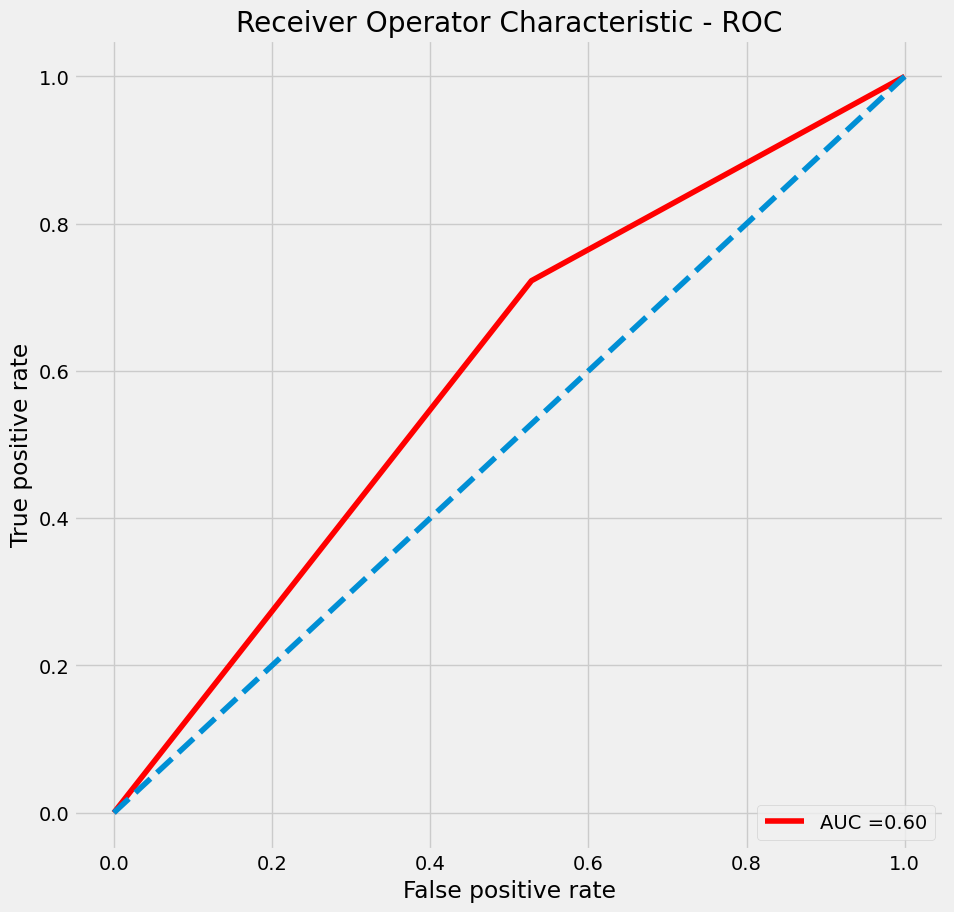

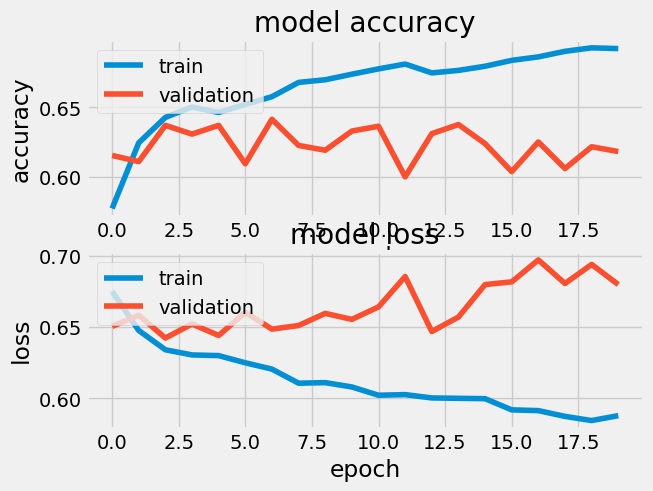

In [208]:
with mlflow.start_run(run_name = 'Simple RNN'):
    
    model_rnn_simple = build_model(nb_words, "SimpleRNN")
    start_training = time.time()
    history=model_rnn_simple.fit(train_X, train_y, epochs=20, batch_size=120,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3, restore_best_weights=True))


end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_simple.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)
    

model_rnn_simple.save('modeles/model_simple_rnn_ss_emb.h5')


##### <a name="C72122"> 7.2.1.2.2 LSTM</a> 

Epoch 1/20
107/107 [==============================] - 20s 129ms/step - loss: 0.6812 - accuracy: 0.5536 - auc: 0.5821 - val_loss: 0.6519 - val_accuracy: 0.6241 - val_auc: 0.6750
Epoch 2/20
107/107 [==============================] - 12s 117ms/step - loss: 0.6455 - accuracy: 0.6258 - auc: 0.6731 - val_loss: 0.6416 - val_accuracy: 0.6350 - val_auc: 0.6821
Epoch 3/20
107/107 [==============================] - 13s 119ms/step - loss: 0.6396 - accuracy: 0.6337 - auc: 0.6844 - val_loss: 0.6379 - val_accuracy: 0.6363 - val_auc: 0.6877
Epoch 4/20
107/107 [==============================] - 11s 106ms/step - loss: 0.6298 - accuracy: 0.6464 - auc: 0.6992 - val_loss: 0.6494 - val_accuracy: 0.6319 - val_auc: 0.6812
Epoch 5/20
107/107 [==============================] - 13s 122ms/step - loss: 0.6272 - accuracy: 0.6525 - auc: 0.7043 - val_loss: 0.6337 - val_accuracy: 0.6425 - val_auc: 0.6917
Epoch 6/20
107/107 [==============================] - 11s 108ms/step - loss: 0.6192 - accuracy: 0.6600 - auc: 0.715

INFO:tensorflow:Assets written to: C:\Users\UTILIS~1\AppData\Local\Temp\tmpnt_1tmfn\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\UTILIS~1\AppData\Local\Temp\tmpnt_1tmfn\model\data\model\assets


Le temps d'entrainement total (en minutes) est :
4.5277112921079
125/125 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

           0       0.61      0.72      0.66      2000
           1       0.66      0.55      0.60      2000

    accuracy                           0.63      4000
   macro avg       0.64      0.63      0.63      4000
weighted avg       0.64      0.63      0.63      4000



,pred_0,pred_1
test_0,1439,561
test_1,904,1096


L'aire sous la courbe ROC est : 0.63


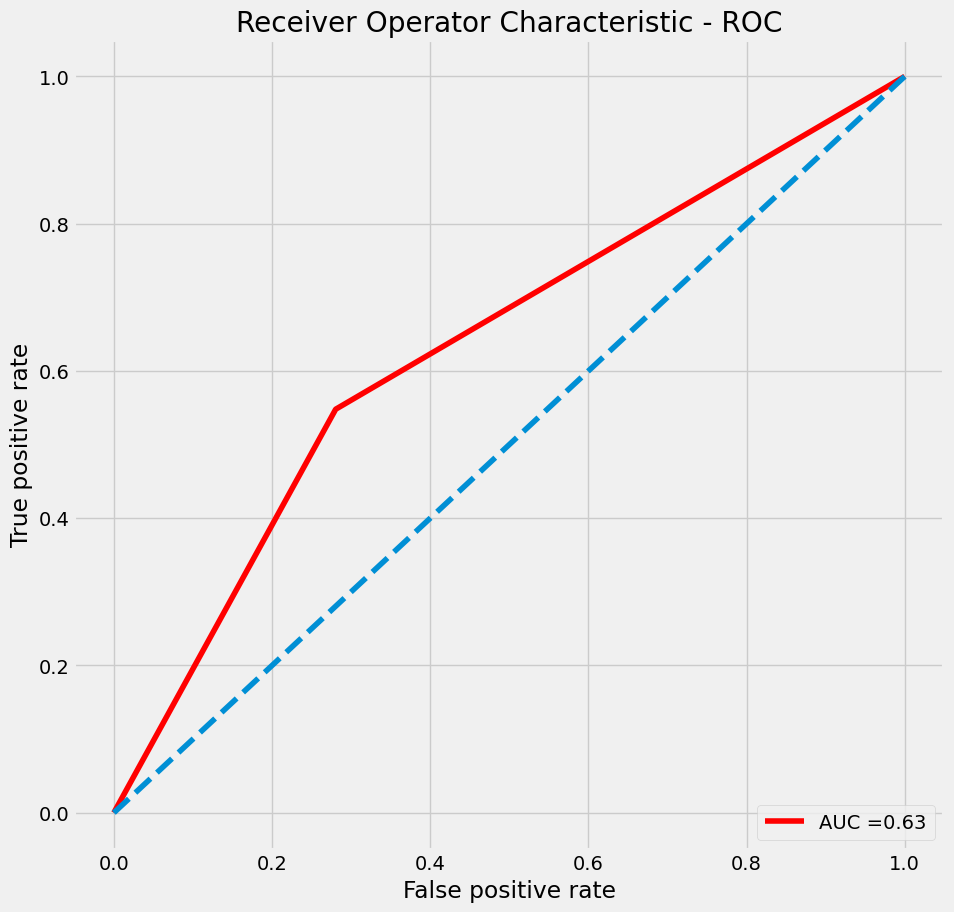

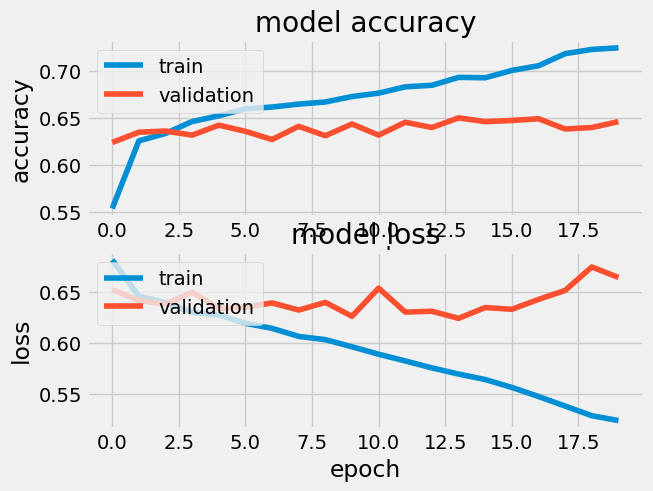

In [209]:
with mlflow.start_run(run_name = 'LSTM'):
    
    model_lstm = build_model(nb_words, "LSTM")
    start_training = time.time()
    history=model_lstm.fit(train_X, train_y, epochs=20, batch_size=120,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))
    
end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_lstm.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

model_rnn_simple.save('modeles/model_lstm_ss_emb.h5')


##### <a name="C72123"> 7.2.1.2.3 GRU</a> 

Epoch 1/20
107/107 [==============================] - 19s 103ms/step - loss: 0.6915 - accuracy: 0.5238 - auc: 0.5328 - val_loss: 0.6797 - val_accuracy: 0.5653 - val_auc: 0.6001
Epoch 2/20
107/107 [==============================] - 10s 97ms/step - loss: 0.6585 - accuracy: 0.6111 - auc: 0.6498 - val_loss: 0.6264 - val_accuracy: 0.6453 - val_auc: 0.7008
Epoch 3/20
107/107 [==============================] - 11s 105ms/step - loss: 0.6394 - accuracy: 0.6332 - auc: 0.6838 - val_loss: 0.6285 - val_accuracy: 0.6541 - val_auc: 0.6997
Epoch 4/20
107/107 [==============================] - 10s 96ms/step - loss: 0.6297 - accuracy: 0.6495 - auc: 0.7007 - val_loss: 0.6328 - val_accuracy: 0.6366 - val_auc: 0.6952
Epoch 5/20
107/107 [==============================] - 11s 103ms/step - loss: 0.6283 - accuracy: 0.6470 - auc: 0.7013 - val_loss: 0.6193 - val_accuracy: 0.6597 - val_auc: 0.7132
Epoch 6/20
107/107 [==============================] - 11s 102ms/step - loss: 0.6237 - accuracy: 0.6545 - auc: 0.7074 

INFO:tensorflow:Assets written to: C:\Users\UTILIS~1\AppData\Local\Temp\tmpt03qagyg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\UTILIS~1\AppData\Local\Temp\tmpt03qagyg\model\data\model\assets


Le temps d'entrainement total (en minutes) est :
4.107807898521424
125/125 [==============================] - 5s 10ms/step
              precision    recall  f1-score   support

           0       0.69      0.59      0.63      2000
           1       0.64      0.73      0.68      2000

    accuracy                           0.66      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.66      0.66      0.66      4000



,pred_0,pred_1
test_0,1173,827
test_1,532,1468


L'aire sous la courbe ROC est : 0.66


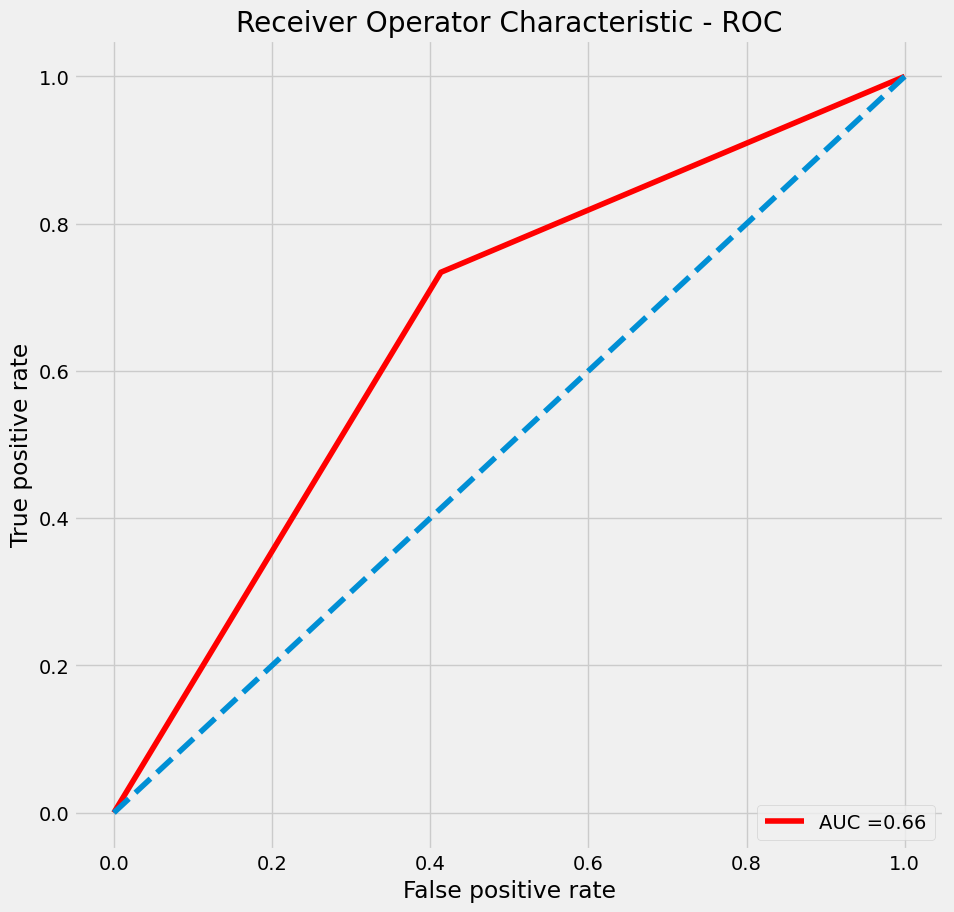

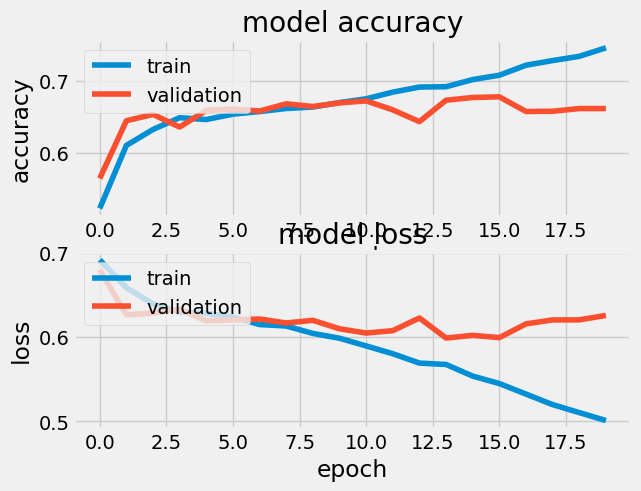

In [210]:
with mlflow.start_run(run_name = 'GRU'):

    model_gru = build_model(nb_words, "GRU")
    start_training = time.time()
    history=model_gru.fit(train_X, train_y, epochs=20, batch_size=120,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_gru.predict(test_X)
predictions = predictions.argmax(axis=1)

score_rnn(predictions, test_y, history)

model_rnn_simple.save('modeles/model_gru_ss_emb.h5')


In [211]:
STOP

NameError: name 'STOP' is not defined

#### <a name="C7213"> 7.2.1.3 Création des modèles avec Embedding Glove</a> 

##### <a name="C72131"> 7.2.1.3.1 Chargement du modèle Glove</a> 

In [ ]:
def load_glove_model(glove_file):
    print("[INFO]Loading GloVe Model...")
    model = {}
    with open(glove_file, encoding='utf8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embeddings = [float(val) for val in split_line[1:]]
            model[word] = embeddings
    print("[INFO] Done...{} words loaded!".format(len(model)))
    return model

In [ ]:
# load the glove model
glove_model = load_glove_model("glove.twitter.27B.200d.txt")

##### <a name="C72132"> 7.2.1.3.2 Création de la matrice embedding avec GLOVE sur les datas</a> 

In [ ]:
# calculate number of words
#nb_words = len(tokenizer.word_index) + 1

# obtain the word embedding matrix
embedding_matrix = np.zeros((nb_words, 200))
for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

##### <a name="C72133"> 7.2.1.3.3 Utilisation de l'embedding</a> 

In [ ]:
mlflow.set_experiment("Embedding : GloVe")
mlflow.tensorflow.autolog()# Ici on fait appel à l'API MLflow qui intégre les algos de TensorFlow. # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)

###### <a name="C721331"> 7.2.1.3.3.1 Simple RNN</a> 

In [ ]:
#Test du Simple RNN avec des valeurs différentes de epoch et batch size

with mlflow.start_run(run_name = 'GloVe - Simple RNN'):
    model_rnn_simple = build_model(nb_words, "SimpleRNN", embedding_matrix)

    start_training = time.time()
    history=model_rnn_simple.fit(train_X, train_y, epochs=10, batch_size=60,
                  validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)


predictions = model_rnn_simple.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
model_rnn_simple.save('modeles/model_simple_rnn_glove.h5')

In [ ]:
#STOP

In [ ]:
with mlflow.start_run(run_name = 'GloVe - Simple RNN'):

    model_rnn_simple = build_model(nb_words, "SimpleRNN", embedding_matrix)

    start_training = time.time()
    history=model_rnn_simple.fit(train_X, train_y, epochs=20, batch_size=120,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_simple.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)



###### <a name="C721332"> 7.2.1.3.3.2 LSTM</a> 

In [ ]:
with mlflow.start_run(run_name = 'GloVe - LSTM'):

    model_lstm = build_model(nb_words, "LSTM", embedding_matrix)

    start_training = time.time()
    history=model_lstm.fit(train_X, train_y, epochs=20, batch_size=120,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_lstm.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
model_lstm.save('modeles/model_lstm_glove.h5')

###### <a name="C721333"> 7.2.1.3.3.3 GRU</a> 

In [ ]:
with mlflow.start_run(run_name = 'GloVe - GRU'):

    model_gru = build_model(nb_words, "GRU", embedding_matrix)

    start_training = time.time()
    history=model_gru.fit(train_X, train_y, epochs=20, batch_size=120,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))
    
end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_gru.predict(test_X)
predictions = predictions.argmax(axis=1)

score_rnn(predictions, test_y, history)

In [ ]:
model_gru.save('modeles/model_gru_glove.h5')

In [ ]:
STOP

#### <a name="C7214"> 7.2.1.4 Création des modèles avec Embedding Word2vec</a> 

##### <a name="C72141"> 7.2.1.4.1 Chargement du modèle W2V</a> 

In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 200

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), df_sentiment_ech["clean_text_lem"]))

In [ ]:
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

In [ ]:
word2vec_path = "GoogleNews-vectors-negative300.bin"

# finalement on va charger le modèle suivant :  chargement de 200 000 mot les plus utilisé dans les information du Corpus Google
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 

In [ ]:
vocab_length=nb_words 

In [ ]:
nb_words

##### <a name="C72142"> 7.2.1.4.2 Création de la matrice d'embedding sur les datas</a> 

In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.key_to_index.__contains__(word):
        embedding_matrix[token] = word2vec_model.key_to_index.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

##### <a name="C72143"> 7.2.1.4.3 Création des modèles</a> 

In [ ]:
mlflow.set_experiment("Embedding : Word2vec")
mlflow.tensorflow.autolog()# Ici on fait appel à l'API MLflow qui intégre les algos de TensorFlow. # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)

In [ ]:
with mlflow.start_run(run_name = 'Word2vec - Simple RNN'):

    model_rnn_simple = build_model(nb_words, "SimpleRNN", embedding_matrix)

    start_training = time.time()
    history=model_rnn_simple.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_simple.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
with mlflow.start_run(run_name = 'Word2vec - LSTM'):

    model_rnn_lstm = build_model(nb_words, "LSTM", embedding_matrix)

    start_training = time.time()
    history=model_rnn_lstm.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_lstm.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
with mlflow.start_run(run_name = 'Word2vec - GRU'):

    model_rnn_gru = build_model(nb_words, "GRU", embedding_matrix)

    start_training = time.time()
    history=model_rnn_gru.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_gru.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

#### <a name="C7215"> 7.2.1.5 Création des modèles avec Embedding FastText</a> 

##### <a name="C72151"> 7.2.1.5.1 Chargement du modèle FastText</a> 

In [ ]:
from gensim.models import FastText

Embedding_dimensions = 200

# Creating Word2Vec training dataset.
Fasttext_train_data = list(map(lambda x: x.split(), X_train["clean_text_lem"]))

In [ ]:
Fasttext_model = FastText(vector_size=Embedding_dimensions, window=3, min_count=1)  # instantiate
Fasttext_model.build_vocab(corpus_iterable=Fasttext_train_data)
Fasttext_model.train(corpus_iterable=Fasttext_train_data, total_examples=len(Fasttext_train_data), epochs=10)  # train
print("Vocabulary Length:", len(Fasttext_model.wv.key_to_index))

##### <a name="C72152"> 7.2.1.5.2 Création de la matrice d'embedding sur les datas</a> 

In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if Fasttext_model.wv.key_to_index.__contains__(word):
        embedding_matrix[token] = Fasttext_model.wv.key_to_index.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

##### <a name="C72153"> 7.2.1.5.3 Création des modèles</a> 

In [ ]:
mlflow.set_experiment("Embedding : FastText")
mlflow.tensorflow.autolog()# Ici on fait appel à l'API MLflow qui intégre les algos de TensorFlow. # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)

In [ ]:
with mlflow.start_run(run_name = 'FastText - Simple RNN'):

    model_rnn_simple = build_model(nb_words, "SimpleRNN", embedding_matrix)

    start_training = time.time()
    history=model_rnn_simple.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_simple.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
with mlflow.start_run(run_name = 'FastText - LSTM'):
    
    model_rnn_lstm = build_model(nb_words, "LSTM", embedding_matrix)

    start_training = time.time()
    history=model_rnn_lstm.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_lstm.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
with mlflow.start_run(run_name = 'FastText - GRU'):

    model_rnn_gru = build_model(nb_words, "GRU", embedding_matrix)

    start_training = time.time()
    history=model_rnn_gru.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))
    
end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_gru.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
model_rnn_gru.summary()

#### <a name="C7216"> 7.2.1.6 Création des modèles avec Embedding USE</a>

##### <a name="C72161"> 7.2.1.6.1 Chargement du modèle Use par Google</a> 

In [ ]:
start_use_charging  = time.time()
    
# Load pre-trained universal sentence encoder model
embed_use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

end_use_charging = time.time()
print("Le temps de chargement total (en minutes) du modèle pré-entrainé est :")
print((end_use_charging - start_use_charging)/60)

##### <a name="C72162"> 7.2.1.6.2 Création de la matrice d'embedding sur les datas</a> 

In [ ]:
review_emb_use_mat = [[]]
i=0
for r in [df_sentiment_ech.clean_text_lem]: #tqdm(
    emb = embed_use_model(r)
    review_emb = tf.reshape(emb, [-1,200]).numpy()
    review_emb_use_mat[i]=review_emb
    i+=1
    


In [ ]:
review_emb_use_mat = np.array(review_emb_use_mat)

review_emb_use_mat=np.reshape(review_emb_use_mat, (len(review_emb), 200))
print(review_emb_use_mat.shape)

In [ ]:
nb_words=len(review_emb_use_mat)
nb_words

##### <a name="C72163"> 7.2.1.6.3 Création des modèles</a> 

In [ ]:
mlflow.set_experiment("Embedding : USE")
mlflow.tensorflow.autolog()# Ici on fait appel à l'API MLflow qui intégre les algos de TensorFlow. # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)

In [ ]:
with mlflow.start_run(run_name = 'USE - Simple RNN'):

    model_rnn_simple = build_model(nb_words, "SimpleRNN",  review_emb_use_mat)

    start_training = time.time()
    history=model_rnn_simple.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_simple.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
with mlflow.start_run(run_name = 'USE - LSTM'):

    model_rnn_lstm = build_model(nb_words, "LSTM", review_emb_use_mat)

    start_training = time.time()
    history=model_rnn_lstm.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

    end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_lstm.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
with mlflow.start_run(run_name = 'USE - GRU'):
    
    model_rnn_gru = build_model(nb_words, "GRU", review_emb_use_mat)

    start_training = time.time()
    history=model_rnn_gru.fit(train_X, train_y, epochs=20, batch_size=12,
              validation_data=(valid_X, valid_y))#, callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))

end_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_training - start_training)/60)

predictions = model_rnn_gru.predict(test_X)
predictions = predictions.argmax(axis=1)
score_rnn(predictions, test_y, history)

In [ ]:
predictions

### <a name="C722"> 7.2.1 BERT</a> 

In [ ]:
STOP

#### <a name="C7211"> 7.2.1.1 Modèle 1 : TFBertForSequenceClassification</a> 

In [ ]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
import pickle

In [ ]:
num_classes=len(df_sentiment_ech.target.unique())
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=(num_classes))


In [ ]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

In [ ]:
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =30,pad_to_max_length = True,return_attention_mask = True)

In [ ]:
tokenized_sequence

In [ ]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

In [ ]:
sentences=df_sentiment_ech['clean_text_lem']
labels=df_sentiment_ech['target']
len(sentences),len(labels)

In [ ]:
#Chargement des Tweet dans BERT TOKENIZER

input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [ ]:
len(input_ids),len(attention_masks),len(labels)

In [ ]:
#Enregistrement et chargement des data dabs les pickle files:
print('Preparing the pickle file.....')

pickle_inp_path='bert_inp.pkl'
pickle_mask_path='bert_mask.pkl'
pickle_label_path='bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

In [ ]:
# Split en donnée d'entrainement et validation
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2,random_state=55, stratify=labels)
print('Train inp shape {} Val input shape {}\\nTrain label shape {} Val label shape {}\\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))
unique, counts = np.unique(train_label, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(val_label, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
#train_label


In [ ]:
#mise en place des metrics

log_dir='tb_bert'
model_save_path='bert_model1.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss =tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#metric = tf.keras.metrics.AUC()
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])#,metric2]) #metric,

In [ ]:
#Entrainement du modèle
mlflow.set_experiment("Embedding : BERT")
mlflow.tensorflow.autolog()# Ici on fait appel à l'API MLflow qui intégre les algos de TensorFlow. # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)

with mlflow.start_run(run_name = 'BERT - TFBertForSequenceClassification'):
    start_bert_training = time.time()
    history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=4,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

end_bert_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_bert_training - start_bert_training)/60)

In [ ]:
# --------------------------------------
# Affichage des courbes accuracy et Loss
# --------------------------------------

plt.figure(1)
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show() 

In [ ]:
#Calcul de la performance
model_save_path='bert_model1.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])#,metric2])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)
#pred_labels = preds.argmax(axis=1)
pred_labels = np.argmax(preds.logits, axis=1)
f1 = f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels))

display(confusion(val_label,pred_labels))

print("L'aire sous la courbe ROC est :",round(roc_auc_score(val_label,pred_labels),2))
false_positive_rate, true_positive_rate, thresholds = roc_curve(val_label,pred_labels)
roc_auc=auc(false_positive_rate, true_positive_rate)

    
plt.figure(figsize=(10,10))
plt.title("Receiver Operator Characteristic - ROC")
plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--')
plt.axis('tight')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [ ]:
#trained_model.evaluate([val_inp,val_mask],batch_size=32)

In [ ]:
STOP

#### <a name="C7212"> 7.2.1.2 Modèle 2 : TFBertModel</a> 

In [ ]:
'''TOKENISATION'''

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.clean_text_lem)):
      encoded = tokenizer.encode_plus(
        
        data.clean_text_lem[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
X_train_bert=X_train.copy()
X_train_bert.reset_index(inplace=True, drop=True)

X_test_bert=X_test.copy()
X_test_bert.reset_index(inplace=True, drop=True)

y_train_bert=y_train.copy()
y_train_bert.reset_index(inplace=True, drop=True)

y_test_bert=y_test.copy()
y_test_bert.reset_index(inplace=True, drop=True)

In [ ]:
train_input_ids,train_attention_masks = bert_encode(X_train_bert,60)
test_input_ids,test_attention_masks = bert_encode(X_test_bert,60)

In [ ]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-large-uncased')

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=6e-6), loss='binary_crossentropy', metrics=['accuracy','AUC'])
    return model

In [ ]:
model = create_model(bert_model)
model.summary()

In [ ]:
#entrainement

mlflow.set_experiment("Embedding : BERT")
mlflow.tensorflow.autolog()# Ici on fait appel à l'API MLflow qui intégre les algos de TensorFlow. # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)

with mlflow.start_run(run_name = 'BERT - TFBertModel'):

    start_bert_training = time.time()

    history = model.fit([train_input_ids,train_attention_masks],y_train_bert.target,validation_split=0.2, epochs=2,batch_size=10)

end_bert_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_bert_training - start_bert_training)/60)

In [ ]:
#test
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)


In [ ]:
'''result = pd.DataFrame(result)
submission = pd.read_csv('sample_submission_bert_m2.csv')
output = pd.DataFrame({'id':submission.id,'target':result[0]})
output.to_csv('sample_submission_bert_m2.csv',index=False)'''

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
f1 = f1_score(y_test_bert,result)
print('F1 score',f1)
print('Classification Report')
print(classification_report(y_test_bert,result))

display(confusion(y_test_bert,result))

print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test_bert,result),2))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_bert,result)
roc_auc=auc(false_positive_rate, true_positive_rate)

    
plt.figure(figsize=(10,10))
plt.title("Receiver Operator Characteristic - ROC")
plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--')
plt.axis('tight')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [ ]:
STOP

#### <a name="C7213"> 7.2.1.3 Modèle 3 : hub.KerasLayer</a> 

In [ ]:
'''trois listes pour trois encodages :

tokens, Encodage hiérarchique classique, un mot = un chiffre
pad_masks, Embedding de position pour exprimer l’emplacement des mots dans une phrase.
segment_ids, Embeddings de segments : BERT peut également prendre des paires de phrases comme entrées pour des tâches, notamment pour des modèle de Question-Réponse, ce ne sera pas notre cas ici, cette liste sera donc rempli de zéros'''

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
#module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"

bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
'''On initialise le tokenizer en allant chercher dans le modèle BERT à la fois la liste de vocabulaire et leur index / chiffre associé et la fonction pour passer les mots en lettres majuscules en minuscules.'''
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(X_train.clean_text_lem.values, tokenizer, max_len=100)
test_input = bert_encode(X_test.clean_text_lem.values, tokenizer, max_len=100)
train_labels = y_train.target.values
test_labels = y_test.target.values

In [ ]:
y_test.head()

##### <a name="C72131"> 7.2.1.3.1 Création du modèle</a> 

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(learning_rate=2e-6), loss='binary_crossentropy', metrics=['accuracy','AUC'])
    
    return model

In [ ]:
model_bert = build_model(bert_layer, max_len=100)

In [ ]:
#Affichage du réseau de neuronne


plot_model(model_bert, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##### <a name="C72132"> 7.2.1.3.2 Transfert Learning</a> 

In [ ]:
#Entrainement des poids des couches ajoutées et calcul du temps d'entrainenement

mlflow.set_experiment("Embedding : BERT")
mlflow.tensorflow.autolog()# Ici on fait appel à l'API MLflow qui intégre les algos de TensorFlow. # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)

with mlflow.start_run(run_name = 'BERT - Hub.KerasLayer'):


    start_bert_training = time.time()

    train_history = model_bert.fit(
        train_input, train_labels,
        validation_split=0.2,
        epochs=5,
        batch_size=32)


end_bert_training = time.time()
print("Le temps d'entrainement total (en minutes) est :")
print((end_bert_training - start_bert_training)/60)

In [ ]:
# --------------------------------------
# Affichage des courbes accuracy et Loss
# --------------------------------------

plt.figure(1)
plt.subplot(211)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(212)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show() 

In [ ]:
model_bert.evaluate(test_input, test_labels)

In [ ]:
model_bert.save('model_bert3.h5')

In [ ]:
#Pour charger le modèle sans réentrainement
#from tensorflow import keras
#model_bert = keras.models.load_model('model_bert.h5')

##### <a name="C72133"> 7.2.1.3.3 Prédiction</a> 

In [ ]:
model_bert.predict(bert_encode(["It's a good test"], tokenizer, max_len=100))

In [ ]:
y_pred=model_bert.predict(test_input)

In [ ]:
# Transformation de y_pred en un vecteur de 1 dimension
y_pred=np.round(y_pred)
y_pred=y_pred.astype(int)
y_pred=np.ravel(y_pred)
y_pred


In [ ]:
#Transformation de y_train en dataframe pour fonctionnement sur la fonction score
y_train_bert_cc=train_labels.copy()
y_train_bert_cc=pd.DataFrame(y_train_bert_cc)
y_train_bert_cc.head()

In [ ]:
def score_bert(estimator, y_pred,X_train,X_test,y_train,y_test):
    print("La proportion de target dans le jeu d'entrainement :")
    print(y_train.value_counts(normalize=True))
    print("La proportion des prédictions faite est :")
    print(pd.Series(y_pred).value_counts(normalize=True)) #Pour utiliser value_counts, il faut transformer notre vecteur en series
    print("--------------------------------------------------------------------------------")
    print("Voici les résultats :")
    '''tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    print(f"score train : {tr_score} ; score test : {te_score}")'''
    print("----------------------------------------")
    display(confusion(y_test, y_pred))
    print("----------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------")
    
    print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test,y_pred),2))
       
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)

    
    plt.figure(figsize=(10,10))
    plt.title("Receiver Operator Characteristic - ROC")
    plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.axis('tight')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

In [ ]:
score_bert(model_bert, y_pred,train_input,test_input,y_train_bert_cc,test_labels)

## <a name="C73"> 7.3 Accès des résultats des modèles sur MLFLOW</a> 

In [ ]:
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2OjG8u6HHosHjCbbWSw66kZpPrZ_7WiUpNvYpbu5qqozeNJwL" 
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [ ]:
STOP

In [ ]:
!mlflow ui

# FIN 

In [ ]:
STOP